# IMPORTS 

All the needed imports for our code.

In [ ]:
import numpy as np
import numpy.random as rd
rd.seed(seed=1) # Positive seed for repeatable result.

########################################

from math import ceil,floor
import pandas as pd
from fractions import Fraction
from six.moves import input as raw_input
from IPython import display
from time import sleep

########################################

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize , ListedColormap , to_rgba , to_hex
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

########################################

import networkx as nx
import inspect
import os, sys
import copy

########################################

from google.colab import drive
import cv2
import glob

########################################

%matplotlib inline

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# ERROR DEFINITION

Implementation of the error use in our code

In [ ]:
class Error(Exception): 
    """
    Abstract class defining how we create and call a generic error.
    """
    def __init__(self,message=""):
        self.message=message #string passing the error message to print out
    
    def __str__(self):
        return self.message

In [ ]:
class ConnectionError(Error):
    """
    Error class generating all errors related to a bad network creation. (missing road/intersection, missing network connection...)
    """

In [ ]:
class TypeCarError(Error):
    """
    Error class generating all errors related to a wrong type of car.
    """

In [ ]:
class TypeRoadError(Error):
    """
    Error class generating all errors related to a wrong type of road.
    """

In [ ]:
class CompileError(Error):
    """
    Error class generating all errors related to a network with bad or no conditioning (missing one function call, or too big step)
    """

In [ ]:
class PriorityError(Error):
    """
    Error class generating an error related to wrong weight values ​​for the definition of priorities or due to an intersection not connected to the network.
    """

In [ ]:
class NotImplementedError(Error):
    """
    Error class generating all errors linked to an abstract class method which has not been proprely implemented
    """

In [ ]:
class ModelImportingError(Error): 
    """
    Error class generating all errors linked to failing to import a model
    """

In [ ]:
class OtherErrors(Error): 
    """
    Error class generating all other type of errors.
    """

# LIBRARY UTILITIES

In [ ]:
class HiddenPrints: # Found here : https://stackoverflow.com/questions/8391411/how-to-block-calls-to-print
    """
    Class defined for hiding print in part of the code
    """
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [ ]:
class Utilities:
    """
    Class used to get all class and method descriptions of the Traffic Network model.
    """
    def __init__(self):
        """
        no attribute
        """
    
    def show_information(self,function):
        """
        show the doc of a function or a class

        Parameters
        ----------
            Function : the function about which we want the doc
            
        Returns 
        -------
            None
        """
        print(function.__doc__)
    
    def get_function_parameters(self,function): 
        """
        return the list of the attributes and default value of a function

        Parameters
        ----------
            Function : the function about which we want the param
            
        Returns 
        -------
            (list tuple) : list of tuple, each tuple corresponds to one arg, 
                          tuple [arg_name, type,  default value] : (string, string, Object)
                          if no default value then [arg_name, type]
        """
        signature = inspect.signature(function)
        list_arg=[]
        for i, j in (signature.parameters.items()):
            if (j.default is inspect.Parameter.empty):
                tmp=(i,type(j.default))
            else:
                tmp=(i,type(j.default),j.default)
            list_arg.append(tmp)

        return list_arg
    
    def get_list_function_name(self,Class):
        """
        return the list of the name of functions for one given class

        Parameters
        ----------
            Class : the class about wich we want the list of functions
            
        Returns 
        -------
            (list str) : the list of the name of the functions
        """
        tmp=inspect.getmembers(Class, predicate=inspect.isfunction)
        return [ x[0] for x in tmp ]
    
    def get_list_function(self,Class):
        """
        return the list of the of function for one class (the object, not its name)

        Parameters
        ----------
            Class : the class about wich we want the list of function
            
        Returns 
        -------
            (list object) : the list of the name of the function
        """
        tmp=inspect.getmembers(Class, predicate=inspect.isfunction)
        return [ x[1] for x in tmp ]
    
    def get_list_class_name(self):
        """
        return the list of the name of class in our model (list of class in memory right now)

        Parameters
        ----------
            None
            
        Returns 
        -------
            (list str) : the list of the name of the class
        """
        tmp = inspect.getmembers(sys.modules[__name__], inspect.isclass)
        return [ x[0] for x in tmp ]
    
    def get_list_class(self):
        """
        return the list of the class in our model (the object, not it's name) (list of class in memory right now)

        Parameters
        ----------
            None
            
        Returns 
        -------
            (list object) : the list of the name of the function
        """
        tmp = inspect.getmembers(sys.modules[__name__], inspect.isclass)
        return [ x[1] for x in tmp ]

    def get_class_attribute(self,Class):
        """
        return the list of the attribute name of a class
        Parameters
        ----------
            Class (object) : the class about wich we want the attribute
            
        Returns 
        -------
            (list object) : the list of the name of the attribute
        """
        class_name=str(Class.__class__.__name__)
        private_attribute_name_begin="_"+class_name
        list_attribute_name=[]
        for i in inspect.getmembers(Class):  
            # To remove methods
            if not inspect.ismethod(i[1]):
                # to remove attribute bound to object and only keeping the one from our actual class
                if (not i[0].startswith('_')):
                    list_attribute_name.append(i[0])
                elif (i[0].startswith(private_attribute_name_begin)):
                    tmp=i[0].replace(private_attribute_name_begin,"")
                    list_attribute_name.append(tmp)
        return list_attribute_name
    
    def show_all(self,more=False):
        """
        print the list of all information concerning our model: all the classes, and all their methods

        Parameters
        ----------
            more (boolean) optional : bolean defining if we also print the list of arg for each function; by default False
            
        Returns 
        -------
            None
        """
        class_list=self.get_list_class()
        class_list_name=self.get_list_class_name()
        s0=""
        indent="    "
        for i in range(len(class_list)):
            s0+=str(class_list_name[i])
            s0+="\n"
            s1=""
            if (more):
                function_list=self.get_list_function(class_list[i])
            function_list_name=self.get_list_function_name(class_list[i])
            for j in range(len(function_list_name)):
                s1+=indent
                s1+=str(function_list_name[j])
                s1+="\n"
                if (more):
                    arg_list=self.get_function_parameters(function_list[j])
                    param_name = " ".join([ str(x[0]) for x in arg_list])
                    s1+=indent*2
                    s1+=param_name
                    s1+="\n"
            s0+=s1
        print(s0)
    
    def get_parent_class(self,Class):
        """
        give the list of parent class (if a class inherits of several classes, it will give a list with multiple element, otherwise, only a list of one class)

        Parameters
        ----------
            Class (Class) : the class about wich we want the information
            
        Returns 
        -------
            (list Class) : list of parent class
        """
        try:
            iter=Class.__bases__
        except AttributeError:
            tmp=Class.__class__
            iter=tmp.__bases__
        except Exception as e:
            print("Unexpected error")
            raise e
        
        list_parent_class=[] #list because of multi-heritage
        for i in iter:
            list_parent_class.append(i)
        return list_parent_class
    
    def get_ancestor_class(self,Class):
        """
        give the list of ancestor class (give all the class from wich this class has inherited, directly or not)

        Parameters
        ----------
            (Class Class) : the class about which we want the information
        
        Returns 
        -------
            (list Class) : list of ancestor class
        """
        try:
            iter=Class.__mro__
        except AttributeError:
            tmp=Class.__class__
            iter=tmp.__mro__
        except Exception as e:
            print("Unespected error")
            raise e
        
        list_parent_class=[] #list because of multi-heritage
        for i in iter:
            list_parent_class.append(i)
        return list_parent_class
    
    def get_subclasses(self,Class):
        """
        give the list of ancestor class (give all the classes from which this class has inherited, directly or not)

        Parameters
        ----------
            (Class Class) : the class about which we want the information
        
        Returns 
        -------
            (list Class) : list of ancestor class
        """
        try:
            tmp=Class.__subclasses__()
            return tmp
        except AttributeError:
            tmp=Class.__class__
            tmp2=tmp.__subclasses__()
            return tmp2
        except Exception as e:
            print("unespected error")
            raise e

# ACCESS

In [ ]:
class Access:
    """
    class to manage everything linked to drive access, reading and writing
    """
    def __init__(self):
        self.__path="/content/drive/My Drive/Road_Network/result/"  #path toward the project directory
        self.__tmp_video="tmp_video/" #name of the folder for storing picture for video
        self.__video="video/" #name of the folder for storing video
        self.__model="model/" #name of the folder where we store network configuration

        #format
        self.__picture_format=".png" #picture format
        self.__video_format=".mp4" #video format
        self.__text_format=".txt" #text format
    
    def __repr__(self):
        """ redefining print """
        s=""
        s+="path "
        s+="\n"
        s+="_"*20
        s+="\n"
        s+="global path : "
        s+=str(self.__path)
        s+="\n"
        s+="temporary picture folder : "
        s+=str(self.__tmp_video)
        s+="\n"
        s+="video folder : "
        s+=str(self.__video)
        s+="\n"
        s+="model folder : "
        s+=str(self.__model)
        s+="\n"
        s+="\n"

        s+="format"
        s+="\n"
        s+="_"*20
        s+="\n"
        s+="picture format : "
        s+=str(self.__picture_format)
        s+="\n"
        s+="video format : "
        s+=str(self.__video_format)
        s+="\n"
        s+="text format : "
        s+=str(self.__text_format)

        return s
    
    def contain_file(self,file_name,path_to_directory): #directory_contains_file
        """
        test if a file is in the directory

        Parameters
        ----------
            file_name (string)              : the name of the file we want to test
            path_to_directory (string) : the path to the directory
        
        Returns 
        -------
            Boolean
        """
        list_file = os.listdir(path_to_directory)

        return (file_name in list_file)

    def save_picture(self,picture,name):
        """
        save the picture in tmp folder

        Parameters
        ----------
            picture (picture object from plt) : the picture object we save
            name (string) : the name of the picture we save
        
        Returns 
        -------
            None
        """
        picture.savefig(self.__path+self.__tmp_video+str(name)+self.__picture_format)
        plt.close()
    
    def transform_list_picture_to_video(self,fps,name): #transform_pictures_to_video
        """
        transform the list of pictures from the temporary picture directory to a video
        and save this video in the video file

        Parameters
        ----------
            fps (int) : frame per second, the number of pictures we place per second in our video
            name (string) : the name of the video we save
        
        Returns 
        -------
            None
        """
        file_name=name+self.__video_format
        path_to_directory=self.__path+self.__video
        if (self.contain_file(file_name,path_to_directory)):
            raise OtherErrors("name already used, please use another name")

        img_array = []
        for filename in glob.glob(self.__path+self.__tmp_video+"*"+self.__picture_format):
            img = cv2.imread(filename)
            height, width, layers = img.shape
            size = (width,height)
            img_array.append(img)
 
        fourcc = cv2.VideoWriter_fourcc(*'MP4V')
        
        out = cv2.VideoWriter(self.__path+self.__video+str(name)+self.__video_format,fourcc, fps, size)
 
        for i in range(len(img_array)):
            out.write(img_array[i])
        out.release()
    
    def suppres_temporary_video_directory(self):   #suppress
        """
        use with cautions
        suppresse all png file in result/tmp/video

        Parameters
        ----------
            None

        Returns 
        -------
            None
        """
        mydir=self.__path+self.__tmp_video
        for i in os.listdir(mydir):
            tmp="".join(reversed(i[-1: -5: -1]))
            if (tmp==".png"):
                file_name=mydir+i
                os.remove(file_name)
    
    def save_model(self,string,name):
        """
        save the network config in the model folder

        Parameters
        ----------
            string (string) :
            name (string) : the name of the file we create
        
        Returns 
        -----
            None
        """
        file_name=name+self.__text_format
        path_to_directory=self.__path+self.__model
        if (self.contain_file(file_name,path_to_directory)):
            raise OtherErrors("name already use, please use another name")
        
        path=self.__path+self.__model+str(name)+self.__text_format
        with open(path, 'w') as model:
            model.write(string)
    
    def load_model(self,name):
        """
        load the network config from the model folder

        Parameters
        ----------
            name (string) : the name of the model we load
        
        Returns 
        -----
            string : the string corresponding to the model we want to load.
        """
        path=self.__path+self.__model+str(name)+self.__text_format
        with open(path, 'r') as model:
            return (model.read())


# SPEED

The different types of speed used in the road class for the calculation of speeds in the latter.

In [ ]:
class Speed:
    """
    Abstract class defining speed class
    """
    
    def speed(*args, **kwargs):
        """
        abstract method defining the speed calculation metrics used for computing speed on a road.
        """
        raise NotImplementedError()


In [ ]:
class TruncatedLinearSpeed(Speed): 
    """
    The function is null everywhere except for a density between 0 and 1, 
    where the speed is constant on [0,1-epsilon] and then linear. 
    N.B : The speed is just a linear function for epsilon equal to 1.
    """


    def __init__(self,coeff=1):
        """
        Parameters
        ----------
            coeff (float) optional : epsilon coefficient of the speed calculation (the smaller it is the higher the speed d)
                                   should be in the interval ]0,1] by default 1
        """
        self.epsilon=coeff #epsilon coefficient of the speed calculation (should be small)

    def speed(self,vmax,l,d):
        """
        calculates the speed on a road
            implement the abstract method

        Parameters
        ----------
            vmax (float) : maximum speed on the road
            l (float) : length of the car
            d (float) : distance from the previous car

        Returns 
        -------
            (float) : the calculated speed
        """
        if (d<l): #to avoid an error following a division by zeros 
            return 0
        v=max(vmax*min(1,(1-(l/d))/self.epsilon),0)
        return v
    
    def __repr__(self):
        s="linear speed calculation function"
        s+=", epsilon : "+str(self.epsilon)
        return s

In [ ]:
#TriangularFDSpeed, FD = fundamental diagram

class TriangularFDSpeed(Speed):    
    """
    Speed from fundamental triangular diagram of traffic flow. Where vmax represent the 
    maximum flow velocity and w the congestion speed.
    """

    def __init__(self,w=1):
        """
        Parameters
        ----------
            w (float) optional : Average congestion speed. Must be positive.
  
        """
        self.congestion_speed = w

    def speed(self,vmax,l,d):
        """
        calculates the speed on a road
            implement the abstract method

        Parameters
        ----------
            vmax (float) : maximum speed on the road
            l (float) : length of the car
            d (float) : distance from the previous car
            

        Returns 
        -------
            (float) : the calculated speed
        """

        v = max( min(vmax , self.congestion_speed*((d/l) - 1)) , 0 )
        return v
    
    def __repr__(self):
        s="Speed from triangular fundamental diagram calculation function"
        return s

# COST

The different types of weights, wich are, the different ways of calculating the shortest path.

Each weights corresponds to a different way of calculating the weights assigned to the roads during the shortest path.

2 examples are the length of the roads, or the time needed to cross it if it's empty.

In [ ]:
class Abstract_weight:
    """
    Abstract class
    class used to define different type of weight for the running cost.
    """
    def __init__(self):
        """
        abstract class
        """

    def __hash__(self):
        """redefine hash to use weight types as key"""
        return hash(str(self))
    
    def __eq__(self, other):
        """redefine eq to use weight types as key"""
        return (self.__class__ == other.__class__)
    
    def calculate_road_weight(self,road):
        """
        Abstract method to redefine
        """
        raise NotImplementedError("this is an abstract method, you must redefine it for your class")

In [ ]:
class Abstract_static_weight(Abstract_weight):
    """
    Abstract class
    every static class weight must inherit from this class.
    Only use for discriminating static from dynamic weight.
    (static weight doesn't change during the simulation, dynamic does, so it must be recomputed at each weight.)
    """

In [ ]:
class Abstract_dynamic_weight(Abstract_weight):

  """
  Abstract class
  every dynamic class weight must inerited this class.
  Only use for discriminting static from dynamic weight.
  (static weight doesn't change during the simulation, dynamic does so it must be recompute at each weight.)
  """

  def __init__(self,v=1e-6):

    """
    Parameters
    ----------
      v (float) optional : Minimal speed. Can't be null.
    """
    self.vmin = v 


Real class

In [ ]:
class Weight_Shortest_Distance(Abstract_static_weight): #Weight_Shortest_Distance
    """
    class used to define different type of weight for the length of a road.
    here: road length
    """
    
    def calculate_road_weight(self,road):
        """
        calculates the weight of the road

        Parameters
        ----------
            road (Road) : the road whose weight is calculated

        Returns 
        -------
            (float) : the weight of the road (here its length)
        """
        return road.l

    def __repr__(self):
        return "Weight_Shortest_Distance"

In [ ]:
class Weight_Travel_Time_Empty(Abstract_static_weight): 
    """
    Class used to define different type of weight for the length of a road.
    Here time that a car would take to cover it when it's empty
    (length/speed with speed = max speed of the road)
    """
    def calculate_road_weight(self,road):
        """
        calculates the weight of the road

        Parameters
        ----------
            road (Road) : the road whose weight is calculated

        Returns 
        -------
            (float) : the weight of the road (here the time it will take to cover it (when it's empty))
        """
        t=road.l/road.vmax
        return t
    
    def __repr__(self):
        return "Weight_Travel_Time_Empty"

In [ ]:
class Weight_Average_Travel_Time(Abstract_dynamic_weight): 
    """
    The time it would take to travel the road by a uniform distribution of cars 
    (the length of each car is equal to the average of the whole length in the road).
    """
    def calculate_road_weight(self,road):
        """
        calculates the weight of the road

        Parameters
        ----------
            road (Road) : the road whose weight is calculated

        Returns 
        -------
            (float) : the weight of the road (here the time it will take to cover it)
        """
        vmax=road.vmax
        n = len(road.cars)
        if (n>0):
            d=road.l/(1+n)
            l= sum([ road.cars[i].length for i in range(n) ])/n #mean of the length of the cars
            v=road.class_speed.speed(vmax,l,d)
            if (v>self.vmin):
                t=road.l/v
            else:
                t=(road.l)/self.vmin
        else:
            t=road.l/vmax
        return t
    
    def __repr__(self):
        return "Weight_Travel_Time_Empty"

In [ ]:
class Weight_Present_Travel_Time(Abstract_dynamic_weight): 
  # modifier
    """
    Time that a car would take to cover it by discretizing the road from the cars position at time t.
    """
    def __division(self,l,v):
        """
        divide l by v, make sure they don't cause a problem of dividing by zeros by sending a huge number (if zeros or close to it is detect)

        Parameters
        ----------
            l (float) : the length
            v (float) : the speed

        Returns 
        -------
            (float) : the time : l/v
        """
        if (v>self.vmin):
            return l/v
        else:
            return l/self.vmin


    def calculate_road_weight(self,road):
        """
        calculates the weight of the road

        Parameters
        ----------
            road (Road) : the road whose weight is calculated

        Returns 
        -------
            (float) : the weight of the road (here the time it will take to cover it)
        """
        n=len(road.cars) #number of cars on the road.
        vmax=road.vmax #max speed on the road
        d=road.l # length of the road
        if (n==0):
            return self.__division(d,vmax)
        else:
            #time between the entry and the car closest to the entry.
            T=0
            d0=road.cars[n-1].position
            l0=road.cars[n-1].length
            v0=road.class_speed.speed(vmax,l0,d0)
            T+=self.__division(d0,v0)

            for i in range(n-1,0,-1): #time between the car i+1 and i (car i+1 is)
                di=road.cars[i].position
                di_1=road.cars[i-1].position
                li=road.cars[i].length          
                vi=road.class_speed.speed(vmax,li,di_1-di)
                T+=self.__division(di_1-di,vi)  

            #time between the car closest to the exit and the exit
            dn=road.cars[0].position
            ln=road.cars[0].length
            vn=road.class_speed.speed(vmax,ln,d-dn)
            T+=self.__division(d-dn,vn)    

            return T
        
    
    def __repr__(self):
        return "Weight_Present_Travel_Time"

# VEHICLE CLASSES

The different types of cars/drivers that circulate on the road network.

Each type corresponds to a different routing stratey and is associated with a different weight (the way it computes its shortest path).

Example: shortest path in time, shortest path in distance.

In [ ]:
class Cars: 
  """
  Class Abstract representing cars on the road network.

  named -1
  """
  def __init__(self,type0,num_road,number0,p,l=1):
      self.number=number0 #number of the car in question
      self.position=p #the position of the car on the road
      
      self.type_road=type0 #the type of the road
      self.position_road=num_road #the number of the road on which the car is.
      self.length=l #the length of the car

      self.color="" #the color of the basic cars (for the graphs)
      self.type_name = -1  #Type of driver
      self.weight=Abstract_weight() #the type of weight used to calculate the path of this type of car

  def get_path(self,previous_state):
      """
      Return the path that the car must follow (the next road key)

      Parameters
      ----------
          previous_state (RoadNetwork) : the road network on which our car travels.

      Returns :
      -------
          (tuple) : (string,int) the key of the next road we want to take
      """
      path=previous_state.get_next_road(self)

      return path

  def __repr__(self):
      """ redefining print """
      s="car number : "
      s+=str(self.number)
      s+=" of length : "
      s+=str(self.length)
      s+=" on the road : "
      s+=str(self.position_road)
      s+=" in : "
      s+=str(self.position)
      s+=" "
      s+=repr(self.weight)

      return s


  def get_car_type(self):  
        """
        give the dict of the different type of cars (class that inherited of Cars)

        Parameters
        ----------
            None
        
        Returns 
        -------
            (dict Class) : dict of child class of Cars (the key of the dict are the type number of a class)
        """
        utilities = Utilities()
        list_class=utilities.get_subclasses(self)
        dict_class=dict()
        for i in range(len(list_class)):
            class_object=list_class[i](0,0,0,0)  #create an instance of Cars to then get the number 'type_name' associated with the type of driver 
            if (class_object.type_name in dict_class.keys()):
                print("Warning, key name confict for Car type")
                message=""
                message+="class : "
                message+=str(dict_class[i].__name__)
                message+=" is already named "
                message+=str(dict_class[i](0,0,0,0).type_name)
                message+="\n"
                message+="class : "
                message+=str(class_object.__class__.__name__)
                message+=" will replace it"
                print(message)
            dict_class[class_object.type_name]=list_class[i]
        return dict_class  

In [ ]:
class Shortest_Distance(Cars): 
    """
    vehicles choosing the shortest path (in distance) (don't care about the others, don't know the traffic state)

    named 0
    """
    def __init__(self,type0,num_road,number0,p,l=1):
        super().__init__(type0,num_road,number0,p,l)
        self.color="black" #the color of Shortest distance cars (for graphs)
        self.type_name=0
        self.weight=Weight_Shortest_Distance() #the type of weight used to calculate the path of this type of car
    
    def __repr__(self):
        """ redefining print """
        s=super().__repr__()
        s+=" Shortest distance"

        return s


In [ ]:
class Shortest_Time(Cars): 
    """
    vehicles choosing the quickest path (in time) (don't care about the others, don't know the traffic state)

    named 1
    """
    def __init__(self,type0,num_road,number0,p,l=1):
        super().__init__(type0,num_road,number0,p,l)
        self.color="purple" #the color of Shortest time cars (for graphs)
        self.type_name=1
        self.weight=Weight_Travel_Time_Empty() #the type of weight used to calculate the path of this type of car
    
    def __repr__(self):
        """ redefining print """
        s=super().__repr__()
        s+=" Shortest time"

        return s

In [ ]:
class Shortest_Average_Travel_Time(Cars): 
    """
    vehicles knowing the current traffic state (average).

    named 2
    """
    def __init__(self,type0,num_road,number0,p,l=1):
        super().__init__(type0,num_road,number0,p,l)
        self.color="red" #the color of the players (for the graphs)
        self.type_name=2
        self.weight=Weight_Average_Travel_Time() #the type of weight used to calculate the path of this type of car
    
    def __repr__(self):
        """ redefining print """
        s=super().__repr__()
        s+=" Shortest average travel time"

        return s
    

In [ ]:
class Shortest_Present_Travel_Time(Cars):
    """
    vehicles knowing exactly the current traffic state.

    named 3
    """
    def __init__(self,type0,num_road,number0,p,l=1):
        super().__init__(type0,num_road,number0,p,l)
        self.color="yellow" #the color of the players (for the graphs)
        self.type_name=3
        self.weight=Weight_Present_Travel_Time() #the type of weight used to calculate the path of this type of car
    
    def __repr__(self):
        """ redefining print """
        s=super().__repr__()
        s+=" Shortest present travel time"

        return s

In [ ]:
class Predefined_Route(Cars):  #path/dict_choice can't be None object !!!
    """
    vehicles following a specific path imposed to them at there creation

    named 4
    """
    def __init__(self,type0,num_road,number0,p,l=1,dict_choice=None):
        super().__init__(type0,num_road,number0,p,l)
        self.color="orange" #the color of predefined cars (for graphs)
        self.type_name=4
        self.weight=None #this car don't use a pod
        self.path=dict_choice #a dict compose of the next road to take : the key is the intersection label : the value is the next road key
    
    def get_path(self,previous_state):
        """
        Returns the path that the car must follow next (the list of road numbers)

        Parameters
        ----------
            previous_state (RoadNetwork) : the road network on which our car travels.

        Returns : 
        -------
            (tuple) : (string,int) the key of the next road we want to take
        """
        inter_num=previous_state.roads[self.type_road,self.position_road].i2 #number of the next intersections

        if len(previous_state.intersections[inter_num].roads_exit)==1:
            return previous_state.intersections[inter_num].roads_exit[0]

        elif len(previous_state.intersections[inter_num].roads_exit)==0:
            raise OtherErrors("no road exit after this one")
        else:
          return self.path[inter_num]
    
    def __repr__(self):
        """ redefining print """
        s=super().__repr__()
        s+=" Predefined route"
        s+="\n"
        s+=repr(self.path)

        return s

The different static objects that make up the network: roads and intersections.

# INTERSECTION

In [ ]:
class Intersection:
    """
    Class representing the intersections of the road network.
    """
    def __init__(self,number0,coordinate_X=0,coordinate_Y=0):
        self.number=number0 # intersection number
        self.roads_entry=[]  # list of roads connected to the intersection (list of dople (string,numbers): -road that enter the intersection
        self.roads_exit=[]  #                                                                              -road that  exit  the intersection
        self.cordX=coordinate_X #graphical position of the intersection
        self.cordY=coordinate_Y

        self.next_road=dict() #the next road to take dictionary on the different types of weight
        self.min_path=dict()  #the shortest path (list of roads), dictionary on the different types of static weight (calculated at the beginning of the system)
        self.min_length=dict()  #the shortest path (list duration), dictionary on the different types of static weight (calculated at the beginning of the system)
        
    def __repr__(self):
        """ redefining print """
        s="intersection "
        s+=str(self.number)
        s+=" positioned in : "
        s+=str(self.cordX)
        s+=" "
        s+=str(self.cordY)
        s+="\n"
        
        s+="connect to roads : "
        for i in range(len(self.roads_entry)):
            s+=str(self.roads_entry[i])
            s+=" "
        s+="/ "
        for i in range(len(self.roads_exit)):
            s+=str(self.roads_exit[i])
            s+=" "
        
        s+="\n"
        s+="shortest path : "
        s+="\n"
        for key in self.min_path.keys():
            s+="    "
            s+="next road : "
            s+=str(self.next_road[key])
            s+=" path : "
            s+=str(self.min_path[key])
            s+=" in "
            s+=str(self.min_length[key])
            s+=" type : "
            s+=str(key)
            s+="\n"
        
        return s
    
    def add_incoming_road(self,type_road,number0): 
        """
        Linked a road to the intersection (the road end at the intersection).

        Parameters
        ----------
            number0 (int) :  number of the road we linked to the intersection

        Returns
        -------
            None.
        """
        self.roads_entry.append((type_road,number0))
    
    def add_outgoing_road(self,type_road,number0): 
        """
        Linked a road to the intersection (the road begin at the intersection).

        Parameters
        ----------
            number0 (int) :  number of the road we linked to the intersection

        Returns
        -------
            None.


        """
        self.roads_exit.append((type_road,number0))
    
    

# ROAD UTILITIES

Class that is used to define each stretch of road in the network as a feature, consisting of two intersections that represent the endpoints and cars that cross the road in question.

In [ ]:
class Road_Utilities:  
    """
    Class representing the roads of the road network.
    """
    def __init__(self,type0,number0,insersection1,insersection2,l1,vm=20,V=TruncatedLinearSpeed()):
        self.number=number0 #road number
        self.type_road=type0 # "normal", "entry" or "exit"

        self.i1=insersection1 #number of the 1st intersection connected to the road (it's input) (-1 if the road is connected to only one intersection (its output))
        self.i2=insersection2 #number of the 2nd intersection connected to the road (it's exit) (-1 if the road is connected to only one intersection (its entry))
        self.l=l1 #length of the road
        self.vmax=vm #maximum possible speed on the road (20 m.s-1 = 72 km)

        self.next_roads=[] #list of roads that can be taken from this road
        self.priority=0 #priority weight (the probability for the road to have priority at the next intersections.)
        self.class_speed=V #the method of calculation of the speed on this road by default the one of the mother class

        self.has_priority=False #init the boolean definnig if a car can pass at the intersection.
        
        self.cars=[] #list of cars (class Car) positioned on this road (the 1st car in the list is the one closest to the exit of the road
            #inversely the last one is the one closest to the road entrance)
    
    def reinitialise_next_roads(self):
        """
        Reset the list of next_roads.
            (removes all roads from next_roads)

        Parameters
        ----------
            None

        Returns 
        -------
            None
        """
        self.next_roads=[]
    
    def add_next_road(self,number0):
        """
        Add a road (its number) to the following list of road.

        Parameters
        ----------
            number (int) : the number of the road added

        Returns 
        -------
            None
        """
        self.next_roads.append(number0)
    
    def __create_car(self,number0,p,l,type0):
        """
        Creates a car of a chosen type and returns it.
        (private method)

        Parameters
        ----------
            type_road (string) : the road type
            number0 (int) : the car number
            p (int) : the position of the car on the road
            l (float) : the length of the car
            type0 (int) : the type of car : 0 = Shortest_Distance, 1 Shortest_Time, 2 Shortest_Average_Travel_Time, 3 Shortest_Present_Travel_Time

        Returns 
        -------
            (Cars) : The cars that we end up creating
        """
        num_road=self.number
        type_road=self.type_road
        try:
            utilities=Utilities()
            cars = Cars(0,0,0,0)
            with HiddenPrints(): #for blocking print in case two car type have the same number (one warning at the creation of the network is enough)
                type_car_dict=cars.get_car_type()#get the dict of all the Car type and there key (type number)
            car_object=type_car_dict[type0](type_road,num_road,number0,p,l)#creation of the car
        except KeyError:
            raise TypeCarError("number "+str(type0)+" doesn't match any type in the car type dict")
        except Exception as e:
            print("unexpected error")
            raise e
        return car_object

    
    def reinitialise_car(self):
        """
        Reset the list of cars.
            (removes all cars from cars list)

        Parameters
        ----------
            None

        Returns 
        -------
            None
        """
        self.cars=[]
    
    def add_car(self,position0,num_car,type0,l):
        """
        Creates and places a car of a chosen type in its place on the road.

        Parameters
        ----------
            position0 (int) : the position of the car on the road
            num_car (int) : the car number
            type0 (int) : the type of car : 0 = Shortest_Distance, 1 Shortest_Time, 2 Shortest_Average_Travel_Time, 3 Shortest_Present_Travel_Time
            l (float) optional : the length of the car by default 1

        Returns 
        -------
            None
        """
        is_place=False #bollean saying if the car has not yet been placed on the road (False = it has not been placed)
        for i in range(len(self.cars)):
            if (position0>self.cars[i].position and not is_place):
                    self.cars.insert(i,self.__create_car(num_car,position0,l,type0))
                    is_place=True
        if (len(self.cars) == 0):
            self.cars.append(self.__create_car(num_car,position0,l,type0))
        else:
            if (position0<self.cars[len(self.cars)-1].position):
                self.cars.append(self.__create_car(num_car,position0,l,type0))
    
    def add_car_object(self,car): 
        """
        Add a car at the beginning of a road.

        Parameters
        ----------
            car (Cars) : the car we want to add

        Returns 
        -------
            None
        """
        self.cars.append(car)
    
    def get_list_car_pos(self): 
        """
        Returns the list of the positions of the cars on this road.
        (list starting from the cars near the end of the road)

        Parameters
        ----------
            None

        Returns 
        -------
            (list int) : the list of cars positions
        """
        liste=[]
        for i in range(len(self.cars)):
            liste.append(self.cars[i].position)
        return liste
    
    def has_car(self,number_car):
        """
        Test if the car in question belongs to the road.

        Parameters
        ----------
            number_car (int) : the number of the car you are looking for

        Returns 
        -------
            (bool) : boolean saying if the car is on the road or not
        """
        boole=False
        for i in range(len(self.cars)):
            if (self.cars[i].number==number_car):
                boole=True
        return boole

            
    def __repr__(self):
        """ redefining print """

        #general information
        s0="road "
        s0+=str(self.number)
        s0+=" from "
        s0+=str(self.i1)
        s0+=" to "
        s0+=str(self.i2)
        s0+=" length : "
        s0+=str(self.l)
        s0+=" priority weight : "
        s0+=str(self.priority)
        s0+=" max speed : "
        s0+=str(self.vmax)
        s0+=" "
        s0+=repr(self.class_speed)
        s0+=" ; car has priority : "
        s0+=str(self.has_priority)

        #next road information
        sn="next road list :"
        for i in range(len(self.next_roads)):
            sn+=str(self.next_roads[i])
            sn+=' , '
        if (len(self.next_roads)>0):
            sn=sn.rstrip(sn[-1])
            sn=sn.rstrip(sn[-1])
            sn=sn.rstrip(sn[-1])

        #cars information
        sv="list cars :"
        for i in range(len(self.cars)):
            sv+="\n"
            sv+="    "
            sv+=repr(self.cars[i])

        s=""
        s+=s0
        s+="\n"
        s+=sn
        s+="\n"
        s+=sv
        return s
    
    def get_cars_pos(self): 
        """
        local part of show_pos_car do all the necessary operation on one road and send back the string
        """
        s="road : "
        s+=str(self.type_road)
        s+=" "
        s+=str(self.number)
        s+="\n"
        s+="    "
        for j in range(len(self.cars)): #loop on the cars
            s+=str(self.cars[j].number)
            s+=": "
            s+=str(self.cars[j].position)
            s+=" ; "
        if (len(self.cars)>0):
            s=s.rstrip(s[-1])
            s=s.rstrip(s[-1])
            s=s.rstrip(s[-1])
        return s

# ROAD NETWORK CLASS

The class representing the road network.

The main class that manages the dynamics of the system.

In [ ]:

class RoadNetwork:
    """
    Class representing a road network.
    """
    def __init__(self,v = 1e-6):
        utilities=Utilities() #create an utility object in order to have access to the Utility method
        cars = Cars(0,0,0,0)

        self.roads=dict() #dictionary storing the Road (for each type of roads)
                          #dict key : (type, num_road)
                          #type :(string: "normal", "entry", "exit")
        self.intersections=dict() #dictionary storing the Intersection
                          #dict key : (int) number of the road
        
        self.__static_weight_list=[ x() for x in utilities.get_subclasses(Abstract_static_weight) ] #list of the different types of static weight used for shortest path calculations
        self.__dynamic_weight_list=[ x() for x in utilities.get_subclasses(Abstract_dynamic_weight(v = v)) ] #list of the different types of dynamic weight used for shortest path calculations
        self.path=dict() #dictionary storing the shortest paths for each road and each type of weight.
                         #dict key : (Weight, num_road), Weight: object of a class inheriting from Weight (each class = a different key)
        
        self.__car_type_dict=cars.get_car_type()#dict of all the car type (the key is the num of the car type, the value is the class.)

        #set of parameters to ensure system stability
        #v_max*dt_max<l is required
        self.__v_max=1 #
        self.__l_min=1 #arbitrary initialization redefined in connect
        self.__dt_max=1#

        self.__length_infinite_road=10**6 #the length of the infinite road (just a number big enought to never reach the end.) 

        self.__dynamic_weight_list_use=None #list of the dynamic weight use during this simuation

        self.__is_well_define=True #as long as nothing is added to the system, all elements are properly connected.
                                   #becomes false as soon as we modify the system. returns to True when we call the connect() function
        self.__is_conditioned=True #same but for cars (dynamic part)
    
    def __repr__(self):
        """
        Returns all the information of the object.
        """
        srn="normal road"
        srn+="\n"
        s0en="entry road"
        s0en+="\n"
        s0ex="exit road"
        s0ex+="\n"
        for i in self.roads: #loop on all the road of the network (get all information about all the road)
            if (self.roads[i].type_road=="normal"):
                srn+=repr(self.roads[i])
                srn+="\n"
            elif (self.roads[i].type_road=="entry"):
                s0en+=repr(self.roads[i])
                s0en+="\n"
            elif (self.roads[i].type_road=="exit"):
                s0ex+=repr(self.roads[i])
                s0ex+="\n"
            else:
                raise TypeRoadError("unidentified road type found")
        
        si="intersections"
        si+="\n"
        for i in (self.intersections):
            si+=repr(self.intersections[i])
            si+="\n"
        
        #part for processing the car type
        soc=""
        for i in self.__car_type_dict:
            soc+=str(i)
            soc+=" "
            soc+=str(type(self.__car_type_dict[i](-1,-1,-1,-1)).__name__)
            soc+=" ; "
        soc=soc.rstrip(soc[-1])
        soc=soc.rstrip(soc[-1]) 

        so=""
        so+="length infinite road : "
        so+=str(self.__length_infinite_road)
        so+="\n"
        so+="list of static Pods : "
        so+=str(self.__static_weight_list)
        so+="\n"
        so+="list of dynamic Pods : "
        so+=str(self.__dynamic_weight_list)
        so+="\n"
        so+="list of Cars type : "
        so+=soc
        so+="\n"
        so+="v_max  : "
        so+=str(self.__v_max)
        so+="\n"
        so+="l_min  : "
        so+=str(self.__l_min)
        so+="\n"
        so+="dt_max : "
        so+=str(self.__dt_max)
        so+="\n"
        so+="est bien définie     : "
        so+=str(self.__is_well_define)
        so+="\n"
        so+="est bien conditionné : "
        so+=str(self.__is_conditioned)

        s=""
        s+=s0en #add information about entry road
        s+="_"*25
        s+="\n"
        s+=s0ex #add information about exit road
        s+="_"*25
        s+="\n"
        s+=srn #add information about normal road
        s+="_"*35
        s+="\n"
        s+=si #add information about intersection
        s+="_"*50
        s+="\n"
        s+=so #add all the other information

        return s
    
    def is_well_defined(self):
        """
        show if the network is well defined

        Parameters
        ----------
            None

        Returns 
        -------
            boolean
        """
        return copy.deepcopy(self.__is_well_define) #copy in order to not get the actual object (stop people from modifing the object)
    
    def set_not_defined(self):
        """
        set the network to not defined. Use by some function outside the class: you should not use it yourself

        Parameters
        ----------
            None

        Returns 
        -------
            None
        """
        self.__is_well_define=False

    def get_dt_max(self):
        """
        give the maximum time step of the network.

        Parameters
        ----------
            None

        Returns 
        -------
            float : the max dt
        """
        return copy.deepcopy(self.__dt_max)
    
    def count_cars_in_network(self): 
        """
        count the number of cars in the network

        Parameters
        ----------
            None

        Returns 
        -------
            (int) : the number of cars in the network
        """
        n = 0
        for road in self.roads.values() : n += len(road.cars)
        return n
    
    def count_cars_by_type(self): 
        """
        count the number of cars in the network for each car type

        Parameters
        ----------
            None

        Returns 
        -------
            (dict int) : the number of cars in the network (the key is the car type)
        """
        dict_car_number=dict()
        #initializing the number for each car type
        for i in self.__car_type_dict : dict_car_number[i] = 0
        
        for road in self.roads.values() : #loop on the roads
            #loop on the cars of the road 
            for car in road.cars : dict_car_number[car.type_name] += 1
        
        return dict_car_number
    
    def get_all_car_info(self,df_cars,df_roads,dt,k): 
        """
        get all information concerning the distribution of vehicles.

        Parameters
        ----------
            df_car : dataframe for cars
            df_roads : dataframe for roads
            dt (float) : time step
            k (int) : iteration rank (in the simulation)


        Returns 
        -------
            (DataFrame) df_car , df_roads
        """
        
        for road_key , road  in self.roads.items() : #loop on the roads

            if (road_key[0] != "exit") and road.cars :
                dict_road = dict()
                dict_road["road type"] , dict_road["road number"] , dict_road["rank time"] , dict_road["number of car"] , dict_road["density"] , dict_road["length"] , dict_road["vmax"] , \
                 dict_road["class speed"] = road_key[0] , road_key[1] , k , len(road.cars) , len(road.cars)/road.l , road.l , road.vmax , road.class_speed

                df_roads = df_roads.append(dict_road,ignore_index=True) # add a dictionnary to the dataframe

                for car_key , car in enumerate(road.cars) : # loop on the cars of the current road 
                    d , l = self.get_distance(road,car_key) , car.length
                    v = road.class_speed.speed(road.vmax,l,d)
                    
                    num_next_road = self.get_next_road(road.cars[0])
                    next_road , next_car = self.roads[num_next_road] , None
                    if next_road.cars : next_car = next_road.cars[-1].number
                    
                    dict_car = dict()
                    dict_car["car number"] , dict_car["rank time"] , dict_car["elapsed time"] , dict_car["weight class"] , dict_car["road position"] , dict_car["speed"] , dict_car["front car distance"], \
                    dict_car["length"] , dict_car["current road"] , dict_car["front car number"] , dict_car["end"] = car.number , k , k*dt , car.weight , car.position , v , \
                    d , l , road_key , next_car , (car.position >= road.l - l)

                    df_cars = df_cars.append(dict_car,ignore_index=True) # add a dictionnary to the dataframe      


        return df_cars , df_roads
    
    #############################################################################################################################
    ##
    ##                        Functions to create and modify the network
    ##
    #############################################################################################################################
        
    def add_intersection(self, label, cordX=0, cordY=0):
        """
        Add an intersection to the network
        (allows to define these graphical coordinates (these coordinates have no impact on the dynamics of the system))

        Parameters
        ----------
            label (int) : the number of the intersection
            cordX (float) optional : the graphical coordinate in x of the intersection by default 0
            cordy (float) optional : the graphical coordinate in y of the intersection by default 0

        Returns 
        -------
            None
        """
        self.__is_well_define=False
        self.intersections[label]=Intersection(label,cordX,cordY)
    
    def set_entry(self,num_inter): 
        """
        Creates the entry road.

        Parameters
        ----------
            num_inter (int) : the number of the intersection of the entry road.

        Returns 
        -------
            None
        """
        self.__is_well_define=False

        if ("entry",0) in self.roads:
            road_key=("entry",0)
            inter_num2=self.roads[road_key].i2
            self.intersections[inter_num2].roads_entry.pop(self.intersections[inter_num2].roads_entry.index(road_key)) #pop on list

        self.roads["entry",0]=Road_Utilities("entry",0,-1,num_inter,self.__length_infinite_road)
        self.intersections[num_inter].add_incoming_road("entry",0)
    
    def set_exit(self,num_inter):
        """
        Creates the exit road.

        Parameters
        ----------
            num_inter (int) : the number of the intersection of the exit road.

        Returns 
        -------
            None
        """
        self.__is_well_define=False

        if ("exit",0) in self.roads:   
            road_key=("exit",0)
            inter_num1=self.roads[road_key].i1
            self.intersections[inter_num1].roads_exit.pop(self.intersections[inter_num1].roads_exit.index(road_key)) #pop on list

        self.roads["exit",0]=Road_Utilities("exit",0,num_inter,-1,self.__length_infinite_road)
        self.intersections[num_inter].add_outgoing_road("exit",0)

    def add_road(self,label,intersections1,intersections2,L=10,vm=20,vclass=TruncatedLinearSpeed()):
        """
        Adds a road to the road network
        does not allow to create the entry and exit roads of the network.

        Parameters
        ----------
            label (int) : the label (number) of the road
            intersections1 (int) : the intersection where the road start
            intersections2 (int) : the intersection where the road finished
            L (float) optional : length of the road; by default 10
            vm (float) optional : maximum speed on the road; by default 20
            vclass (Speed) optional : class of speed calculation on a road; by default TruncatedLinearSpeed()
        
        Returns
        -------
            None
        """
        self.__is_well_define=False

        self.roads["normal",label]=Road_Utilities("normal",label,intersections1,intersections2,L,vm,vclass)
        self.intersections[intersections1].add_outgoing_road("normal",label)
        self.intersections[intersections2].add_incoming_road("normal",label)
    
    def set_intersection_priority(self,num_inter,liste_priority):
        """
        Change the priority of all the road arriving to an intersection.

        Parameters
        ----------
            num_inter (int) : the number of the considered intersection
            liste_priority (list tuple) : list compose of the key and priority of the road,
                                          list of : (( type_road , num_road ) , priority):
                                          type_road (string) : the type of the road
                                          num_road (int) : the number of the road
                                          priority (float) : the priority (weight) we set to the road (must be beetween 0 and 1)

        Returns 
        -------
            None
        """

        n=len(self.intersections[num_inter].roads_entry)
        k=len(liste_priority)
        total_weight=0 #sum of the weight we set to the road
        for i in range(k):
            weight=liste_priority[i][1]
            if (weight<0):
                raise OtherErrors("invalid priority weight : weight can't be negative")
            total_weight+=weight

        
        if (k>n):
            message="too many roads specified for the corresponding intersection"
            message+="\n"
            message+="intersections : "+str(num_inter)+" has "+str(n)+" road arriving at this intersection, "
            message+=str(k)+" road priority where given."
            raise  ConnectionError(message)
        
        elif (k==n): #case where we specify the priority of each road
            if (total_weight!=1):
                message="for intersection "+str(num_inter)+", sum of weights not equal to 1"
                raise PriorityError(message)
            else:
                remaining_weight=0
        else:
            if (total_weight>1):
                message="for intersection "+str(num_inter)+", invalid priority weight : sum of weights can't be greater than 1"
                raise PriorityError(message)
            remaining_weight=(1-total_weight)/(n-k)#the weight of the road we didn't specify (there all equal and complete the total sum of weight to reach 1)

        dic_of_weight=dict()
        for i in range(n):
            dic_of_weight[self.intersections[num_inter].roads_entry[i]]=remaining_weight
        for i in range(k):
            dic_of_weight[liste_priority[i][0]]=liste_priority[i][1]

        for j in dic_of_weight:
            self.roads[j].priority=dic_of_weight[j]
    
    #############################################################################################################################
    ##
    ##                        Utility functions to perform various static operations on the network
    ##
    #############################################################################################################################
    
    
    def get_path_weight(self,path,weight=Weight_Shortest_Distance()):
        """
        Takes a list of paths as argument (a path is a list of roads) and computes their total length.

        Parameters
        ----------
            path (list list int) : the numbers of the roads we travel on
            weight (Weight) optional : an object defining the type of weight used for the calculation by default Weight_Shortest_Distance()

        Returns 
        -------
            (list float) : the list of lengths of the paths in question
        """
        length_list=[]
        for i in range(len(path)):#loop on the differente path
            length=0
            for j in range(len(path[i])): #loop on the road of the path
                length+=weight.calculate_road_weight(self.roads[path[i][j]])
            length_list.append(length)
        return length_list
    
    def __reset_passage_priority(self,inter_num):
        """
        Private function that resets the passage priority of every road at an intersection.

        Parameters
        ----------
            inter_num (int) : the number of the intersection where we reset the passage priority

        Returns 
        -------
            None
        """
        list_inter_road=self.intersections[inter_num].roads_entry
        for i in list_inter_road:
            self.roads[i].has_priority=False


    def __compute_order_of_passing(self,inter_num):
        """
        Private function that computes and sets the order of passage of cars at an intersection.
        The order of passage is randomly compute using the priority weight of each road

        Parameters
        ----------
            inter_num (int) : the number of the intersection where we set the order of passage

        Returns 
        -------
            (list int) : the list of the index of road sort by priority.
            (list (string,int)) : list of all the road arriving to the intersection (inter_num).
        """
        list_inter_road=self.intersections[inter_num].roads_entry #list of all the road arriving to the intersection.
        n = len(list_inter_road)

        list_weights = [ self.roads[x].priority for x in list_inter_road ]
        list_weight_sum = [ sum(list_weights[:i]) for i in range(n+1) ] #list of float going up beetwen 0 and 1. use to choose the road using the weight priority of a road

        p = rd.uniform(0,1) #draw of an float use to define the priority road
        i = [ index for index,value in enumerate(list_weight_sum) if (value < p) ][-1] #find the priority road

        order = [ i+j if (j<=n-1-i) else j for j in range(n) ] #loop to define the priority order of the other roads (road before/after the priority road in the list)

        return order , list_inter_road



    def __set_priority(self,inter_num):
            """
            Change the priority state on each road deciding if cars can pass.
            Roads have priority status until a road has a car at its end (according to the order of passage).

            Parameters
            ----------
                inter_num (int) : the number of the intersection where we do our operation.

            Returns 
            -------
                None
            """

            order_of_passing , list_inter_road = self.__compute_order_of_passing(inter_num) # chose the order of priority (wich road has priority, wich road has priority after the first road...)

            self.__reset_passage_priority(inter_num)

            for i in order_of_passing : # loop on the index priority of each road
                if self.roads[list_inter_road[i]].cars : # test if there is a cars on the road  
                    self.roads[list_inter_road[i]].has_priority = True
                    road_length , front_car_position , front_car_length = self.roads[list_inter_road[i]].l , self.roads[list_inter_road[i]].cars[0].position , self.roads[list_inter_road[i]].cars[0].length
                    if ( front_car_position >= road_length-front_car_length ) : break # test if the cars is at the end of the road and stop the process
            


    def connect(self):
        """
        Makes all the connections and calculations that can only be done after adding all the roads and intersections.
        Must be executed after each modification of the system architecture.

        recalculates all the next/shortest path for each road and updates this information, connects the roads (in their attribute), ...

        Parameters
        ----------
            None

        Returns 
        -------
            None
        """
        self.__v_max=0
        #does the connection to the road
        for i in self.roads:
            if (self.roads[i].type_road=="normal" or self.roads[i].type_road=="entry"):
                
                inter=self.intersections[self.roads[i].i2]
                self.roads[i].reinitialise_next_roads() #reinitialize the list of roads connected to the end of this road
                for j in range(len(inter.roads_exit)):
                    sortie=inter.roads_exit[j] #the number of the road starting from the intersection (in the list of roads starting from the intersection)
                    self.roads[i].add_next_road(sortie)
            
            elif (self.roads[i].type_road=="exit"):
                pass
            else:
                message="name : "+str(self.roads[i].type_road)+" is not a valid type name"
                message+="\n"
                message+="normal ; exit ; entry ; are the current valid name"
                raise ConnectionError(message)

            if (self.roads[i].vmax>self.__v_max):#test if the road has a higher speed to find the maximum speed of all roads.
                self.__v_max=self.roads[i].vmax
        

        #calculate the weight of each segment (the time it would take the car to cover it) and create the corresponding graph

        for weight in (self.__static_weight_list): #loop on static weight types
            for i in self.intersections:#loop on the intersection.
                try:
                    self.__set_path(weight,i)
                except nx.NetworkXNoPath:
                    message="this configuration doesn't allow to be able to reach the exit from everywhere, please change this before carrying on"
                    raise ConnectionError(message)
                except Exception as e:
                    print("unespected error")
                    raise e
        
        for weight in (self.__dynamic_weight_list): #Loop on the types of dynamic weights
            for i in self.intersections:#loop on the intersection.
                self.__set_path(weight,i)
        
        for i in self.intersections: #init the weight priority of the road at the intersection.
            self.set_intersection_priority(i,[])

        self.__is_conditioned=False #some information like road max speed can have change.
        self.__is_well_define=True #we have made all the connections so the network is well defined



    

    def compile_car_system(self):
        """
        Makes all the calculations that can be done only after adding all the cars.
        Executed after each addition/removal of car from the system.

        Makes the calculations of l_min and dt_max of the system so that it is well conditioned.

        Parameters
        ----------
            None

        Returns 
        -------
            None
        """
        if (self.__is_well_define):
            self.__l_min=10**6
            liste_poid=[]
            for i in (self.roads):
                for j in range(len(self.roads[i].cars)):
                    car=self.roads[i].cars[j]
                    if (car.length<self.__l_min):#test if the road has a higher speed to find the maximum speed of all roads.
                        self.__l_min=self.roads[i].cars[j].length
                    if (not (car.weight in liste_poid)):#test if a car already use one of the pod
                        liste_poid.append(car.weight)#added the new weight to the list.
            liste_poid_dynamic_tmp=[]
            for i in range(len(self.__dynamic_weight_list)):
                if (self.__dynamic_weight_list[i] in liste_poid):
                    liste_poid_dynamic_tmp.append(self.__dynamic_weight_list[i])
              
            self.__dt_max=self.__l_min/self.__v_max
            self.__dynamic_weight_list_use=liste_poid_dynamic_tmp #the dynamic weight we use
            self.__is_conditioned=True
        else:
            raise ConnectionError("before compiling the car info you must connect the roads with connect()")

    def road_reset(self):
        """
        Supresses all the cars in the network to get an empty network.

        Parameters
        ----------
            None

        Returns 
        -------
            None
        """
        for i in (self.roads):
            self.roads[i].cars=[]
    
    def position_car(self,type_road,road_num,list_type,l):
        """
        Positions n (n is the length of the list type) cars on the road road_num, equidistant from each other.
        The type is specify by list type (private function).

        Parameters
        ----------
            type_road (int) : the type of the road
            road_num (int) : the number of the road on which the cars are placed
            list_type (list int)  : list of the type we place: 0 = Shortest_Distance, 1 Shortest_Time, 2 Shortest_Average_Travel_Time, 3 Shortest_Present_Travel_Time
            l (float) : length of the cars

        Returns 
        -------
            None
        """
        self.__is_conditioned=False
        
        n=len(list_type)

        if (type(road_num)==int or type(road_num)==float): #test if road_num is a number
            num_tmp=road_num
        else:
            num_tmp=-1
        
        self.roads[type_road,road_num].reinitialise_car()

        if (type_road=="normal"): #case normal road
            k=self.roads[type_road,road_num].l
            for j in range(n):
                p=k*(j+1)/(n+1)
                self.roads[(type_road,road_num)].add_car(p,num_tmp*n+j,list_type[j],l)
        
        elif (type_road=="entry"): #case entry road
            ecart=self.roads[type_road,0].l-(n+1)*2*l #the place on the road where we start putting cars
            k=(n+1)*2*l
            for j in range(n):
                p=ecart+(k*(j+1)/(n+1))
                self.roads[type_road,0].add_car(p,num_tmp*n+j,list_type[j],l)
        
        elif (type_road=="exit"): #case exit road
            k=(n+1)*2*l
            for j in range(n):
                p=k*(j+1)/(n+1)
                self.roads[type_road,0].add_car(p,num_tmp*n+j,list_type[j],l)
        
        else:
            raise IndexError("the road type "+str(type_road)+" doesn't exist")
    
    
    def shortest_path(self,p,inter_num):
        """
        Private function
        compute all the shortest path beetween one intersections, and the intersection connect to the exit road

        Parameters
        ----------
            p (Weight) : class defining the type of weight used for the shortest path algorithm.
                calculate_road_weight is the important function to define when creating a weight class.
            inter_num (int) : the number of the intersection of wich we compute the shortest path toward the exit.
        Returns 
        -------
            (list list tuple) a list of path: each path is a list of tuple
                                list : the key of the road composing  the shortest path, tuple : the key of the road : (type_road, num_road)
        """

        G = nx.DiGraph()
        #calculate the weight of each segment (the time it would take the car to cover it) and create the corresponding graph
        for i in (self.roads):
            road=self.roads[i]
            weight=p.calculate_road_weight(road)
            G.add_edge(road.i1,road.i2,weight=weight,num_road=i)
                
        num_exit_inter=self.roads["exit",0].i1

        path=[]
        
        tmp=nx.all_shortest_paths(G,source=inter_num,target=num_exit_inter,weight='weight')#compute the shortest path

        for pathway_inter in tmp: #loop on the different path beetween 2 points
            if (len(pathway_inter)>1):#test if a path exist.
                pathway_road=[]
                for j in range(len(pathway_inter)-1):#loop on one path 
                    pathway_road.append(G[pathway_inter[j]][pathway_inter[j+1]]['num_road'])
                path.append(pathway_road)
        return path
    

    def __set_next_road_path(self,weight,inter_num,path):
        """
        Private function
        compute and set the list of all the first road in the shortest path from one intersection to the exit.

        Parameters
        ----------
            weight (Weight) : class defining the weight that was use for the shortest path
            inter_num (int) : the number of the intersection
            path (list list tuple) :  a list of path: each path is a list of tuple
                                list : the key of the roads composing the shortest path, tuple : the key of the road : (type_road, num_road)
        
        Returns 
        -------
            (None)  
        """
        num_exit=self.roads["exit",0].i1

        self.intersections[inter_num].min_path[weight]=path
        self.intersections[inter_num].min_length[weight]=self.get_path_weight(path,weight)

        if (inter_num==num_exit):
            self.intersections[inter_num].next_road[weight] = [("exit",0)] # set the next road as the exit road when the next intersection is the exit intersection
        else:
            if path :
                tmp=[]
                for x in path : tmp.append(x[0])
                self.intersections[inter_num].next_road[weight] = tmp # set the list of next road to go (one road per path) in the general case
            else :
                self.intersections[inter_num].next_road[weight] = None # set None when no path is availlaible to reach the exit intersection from this intersection.

    def __set_path(self,weight,inter_num):
        """
        set all the information link to the path with a specific weight.

        Parameters
        ----------
            weight (Weight) : class defining the type of weight used for the shortest path algorithm.
                calcul_poid_road is the important function to define when creating a weight class.
            inter_num (int) : the number of the intersection.
        Returns 
        -------
            (None)
        """
        path=self.shortest_path(weight,inter_num)
        self.__set_next_road_path(weight,inter_num,path)

    def get_next_road(self,car):
        """
        return the next road the car must take

        Parameters
        ----------
            car (Cars) : the car about wich we want to find the next road
        Returns 
        -------
            (tuple) : (string,int) the key of the next road we want to take
        """
        weight = car.weight
        road_key=(car.type_road,car.position_road)
        next_roads_list=self.intersections[self.roads[road_key].i2].next_road[weight] #we get the list of the next possible road for this car, in order to take the shortest path

        n=len(next_roads_list)
        if (n==1):
            return next_roads_list[0]
        elif (n>1):
            return next_roads_list[rd.randint(n)]
        else: raise OtherErrors("no available path toward exit for this car.")


    #############################################################################################################################
    ##
    ##                        Function to interact with cars on the network
    ##
    #############################################################################################################################

    def __inter_has_car_close(self,inter_num):
        """
        Return True if a car coming toward the intersection is close to it (closer than it's length l).

        Parameters
        ----------
            inter_num (int) : the number of the intersection.
        Returns 
        -------
            (boolean) : True if a car coming toward the intersection is close to it
        """
        list_road = self.intersections[inter_num].roads_entry # list of roads arriving to the intersections

        for typ , num in list_road : # loop on the roads arriving to the intersections
            road = self.roads[typ,num]
            if road.cars : # test if there are cars on the road
                car = road.cars[0] # the first car of the current road.
                l , p , L = car.length , car.position , road.l #car.length 
                if (p>L-l) : return True # test if the car is close to the intersection
        return False

    def get_distance_previous_car(self,type0,num_road,num_car):
        """
        Finds the distance between the current car and the car ahead.
        If the car has no car in front of it on this road returns the distance from the car to the end of the road.

        Parameters
        ----------
            type0 (string) : the type of road
            num_road (int) : the number of the road on which the car is considered
            num_car (int) : the position in the car list of the car being considered
        Returns 
        -------
            (float) : the distance to the previous car
        """
        road=self.roads[type0,num_road]
        position1=road.cars[num_car].position #our car
        if (num_car == 0):
            position2=road.l
        else:
            position2=road.cars[num_car-1].position #the car in front of us.
        return (position2-position1)

    def get_distance(self,road,car_number) :
        """
        Finds the distance between the current car and the car ahead (taking into account the case where the car in front is on the next road).

        Parameters
        ----------
            road (RoadUtilities) : current road
            car_number (int) : the index of the car

        Returns 
        -------
            (float) : the distance to the previous car
        """

        if road.cars and (road.type_road !="exit") : 
            d =  self.get_distance_previous_car(road.type_road,road.number,car_number)
            num_next_road = self.get_next_road(road.cars[0])
            next_road = self.roads[num_next_road]
            if car_number == 0 : 
                if next_road.cars : d += next_road.cars[-1].position
                else : d += next_road.l
            return d

    def particule_move(self,v,dt,type_road,num_road,num_car,d,l): 
        """
        Moves the car on its current road.

        Parameters
        ----------
            v (float) : the speed at which the car should go
            dt (float) : the time step
            num_road (int) : the number of the road in question
            num_car (int) : the index of the car in the list of cars on the road
            d (float) : the distance the car has in front of it (distance to the next intersection if it does not have priority, or to the car in front of it in other cases).
            
        Returns 
        -------
            None
        """
        # #test if you can hit the car in front of you
        # if (d-v*dt<l):
        #     increment=max(0,d-l) #move while not going closer to the car before, than the length of our car. (can also be distance to the intersection)
        #     #raise OtherErrors("Collision between two cars (distance < car length)")
        # else:
        increment=v*dt
        
        self.roads[(type_road,num_road)].cars[num_car].position += increment


    def step_road_move(self,dt,previous_state,road):
        """
        Function called each time step and moving all cars on a road with respect of the follow-the-leader model.

        Parameters
        ----------
            dt (float) : the step
            previous_state (RoadNetwork) : copy of the network (the previous state of the network)
            road (Road) : the road on which we move the cars
            
        Returns 
        -------
            None
        """
        #case car at the end of the road.
        if road.cars : #test if there is a car on the road.

            # information on the road
            L , num_road , type_road , vmax  = road.l , road.number , road.type_road , road.vmax 
            road_priority = previous_state.roads[type_road,num_road].has_priority 
            if type_road != "exit" : num_next_road = previous_state.get_next_road(road.cars[0])
     

            # information of the first vehicle
            l , d , position = road.cars[0].length , previous_state.get_distance_previous_car(type_road,num_road,0) , road.cars[0].position    

            if (position>=L-l): #test if our car is at the end of the road (criterion distance lower than the length of the vehicle.)
                if road_priority : #the car has priority
                    if previous_state.roads[num_next_road].cars : # test if there is a car on the next road.
                        d+=previous_state.roads[num_next_road].cars[-1].position                   
                    else:
                        d+=previous_state.roads[num_next_road].l               
                v=road.class_speed.speed(vmax,l,d)
            else:
                v=vmax #we go at the maximum possible speed (see 1381 paper)
            self.particule_move(v,dt,type_road,num_road,0,d,l) # moving the car
        
        # The other cars
        for k , car in enumerate(road.cars[1:]) :
            car_next = road.cars[k]
            d , l , l_front = self.get_distance_previous_car(type_road,num_road,k+1) , car.length , car_next.length  
            minimum_gap = (l+l_front)/2
            v = road.class_speed.speed(vmax,minimum_gap,d)
            self.particule_move(v,dt,type_road,num_road,k+1,d,minimum_gap) # moving the other car 

            
    
    def step_road_transfere(self,road):
        """
        Function that transfers the cars that have passed the end of the road to the next corresponding road.

        Parameters
        ----------
            road (Road) : the road where we will perhaps transfer the car
            
        Returns 
        -------
            None
        """
        #check if the car at the end of the road is out of it
        num_road=road.number
        type_road=road.type_road
        index=(type_road,num_road)

        if (type_road=="normal" or type_road=="entry"): #case normal road
            if (len(self.roads[index].cars)>0):
                if (self.roads[index].cars[0].position>=self.roads[index].l) : #case car at the end of the road
                    car=self.roads[index].cars[0]
                    car.position=car.position-self.roads[index].l
                    self.roads[index].cars.pop(0) #removal of the car from the old road

                    num_next_road=road.cars[0].get_path(self)

                    (car.type_road,car.position_road)=num_next_road
                    self.roads[num_next_road].add_car_object(car) #adding the car to the new road

        elif (type_road=="exit"): #case road exit
            pass #we don't do anything here
        else:
            raise IndexError("error road "+str(num_road)+" has an invalid road type")



    def step(self,dt):
        """
        Makes all cars move one step (depending on the system dynamics).

        Parameters
        ----------
            dt (float) : the time step, by how much do we advance
            
        Returns 
        -------
            None
        """
        if (self.__is_well_define):
            if (self.__is_conditioned):
                if (0<dt<self.__dt_max):
                    #calculates the weights of the road and the new shortest paths
                    for i in self.intersections: #loop on the intersection.
                        if (self.__inter_has_car_close(i)): #test if there a car close to the intersection coming toward it.
                            for weight in (self.__dynamic_weight_list_use): #loop on dynamic weight types
                                self.__set_path(weight,i)

                    for i in self.intersections: #chose randomly the priority of the road for this intersection.
                        self.__set_priority(i)
                    
                    previous_state=copy.deepcopy(self)

                    #makes the cars move
                    for i in (previous_state.roads): #loop on normal roads
                        self.step_road_move(dt,previous_state,previous_state.roads[i])


                    #changes the road of the cars that have passed the end of the road
                    for i in (previous_state.roads): #loop on normal roads
                        self.step_road_transfere(previous_state.roads[i])

                else:
                    message="Warning : step dt "+str(dt)+" must be positive and smaller than "+str(self.__dt_max)
                    message+="\n"
                    message+=" new step automatically chosen : "+str(self.__dt_max/2)
                    print(message)
                    self.step(self.__dt_max/2) #try again with impossibility to end up in the same case.
            else:
                self.compile_car_system()
                if (not self.__is_conditioned):
                    raise CompileError("unable to suceffuly compile network")
                else:
                    self.step(dt) #try again with impossibility to end up in the same case.
        else:
            self.connect()
            if (not self.__is_well_define):
                raise ConnectionError("unable to suceffuly compile network")
            else:
                self.step(dt) #try again with impossibility to end up in the same case.
    

    # def step(self,dt,counter=False):
    #     """
    #     Makes all cars move one step (depending on the system dynamics).

    #     Parameters
    #     ----------
    #         dt (float) : the time step, by how much do we advance
            
    #     Returns 
    #     -------
    #         None
    #     """
    #     if (self.__is_well_define):
    #         if (self.__is_conditioned):
    #             if (0<dt<self.__dt_max):
    #                 #calculates the weights of the road and the new shortest paths
    #                 for i in self.intersections: #loop on the intersection.
    #                     if (self.__inter_has_car_close(i)): #test if there a car close to the intersection coming toward it.
    #                         for weight in (self.__dynamic_weight_list_use): #loop on dynamic weight types
    #                             self.__set_path(weight,i)

    #                 for i in self.intersections: #chose randomly the priority of the road for this intersection.
    #                     self.__set_priority(i)
                    
    #                 previous_state=copy.deepcopy(self)

    #                 #makes the cars move
    #                 for i in (previous_state.roads): #loop on normal roads
    #                     self.step_road_move(dt,previous_state,previous_state.roads[i])


    #                 #changes the road of the cars that have passed the end of the road
    #                 for i in (previous_state.roads): #loop on normal roads
    #                     self.step_road_transfere(previous_state.roads[i])
                        
    #                 if counter :
    #                     Collision_list =  [ 0 , 0 ]
    #                     for road in previous_state.roads.values() :
    #                         L = road.l
    #                         if road.cars and (road.type_road !="exit"): 
    #                             num_next_road=previous_state.get_next_road(road.cars[0])
    #                             for k , car in enumerate(road.cars) :
    #                                 l , x = car.length , car.position
    #                                 d =  previous_state.get_distance_previous_car(road.type_road,road.number,k)
    #                                 if k == 0 :
    #                                     if previous_state.roads[num_next_road].cars : d += previous_state.roads[num_next_road].cars[-1].position
    #                                     else : 
    #                                         Lp = previous_state.roads[num_next_road].l
    #                                         d += Lp
    #                                 if d < l :
    #                                     if k == 0 : Collision_list[0] += 1
    #                                     else : Collision_list[1] += 1
    #                     return Collision_list                          

    #             else:
    #                 message="Warning : step dt "+str(dt)+" must be positive and smaller than "+str(self.__dt_max)
    #                 message+="\n"
    #                 message+=" new step automatically chosen : "+str(self.__dt_max/2)
    #                 print(message)
    #                 self.step(self.__dt_max/2) #try again with impossibility to end up in the same case.
    #         else:
    #             self.compile_car_system()
    #             if (not self.__is_conditioned):
    #                 raise CompileError("unable to suceffuly compile network")
    #             else:
    #                 self.step(dt) #try again with impossibility to end up in the same case.
    #     else:
    #         self.connect()
    #         if (not self.__is_well_define):
    #             raise ConnectionError("unable to suceffuly compile network")
    #         else:
    #             self.step(dt) #try again with impossibility to end up in the same case.
    

                
    def replace(self,length=100):
        """
        Transfers the cars from the exit road to the entry road.

        Parameters
        ----------
            length (float) optional : the simulated length of the exit / entry road, 100 by default
            
        Returns 
        -------
            None
        """
        for i in range(len(self.roads["exit",0].cars)):
            car=self.roads["exit",0].cars[0]
            car.position=self.roads["entry",0].l-length+car.position
            car.position_road=0
            car.type_road="entry"
            self.roads["exit",0].cars.pop(0)
            self.roads["entry",0].add_car_object(car)

    def run(self,dt,n):
        """
        Execute n step.

        Parameters
        ----------
            dt (float) : the time step, by how much do we advance
            n (int) : how many time steps we execute
            
        Returns 
        -------
            None
        """        
        for i in range(n):
            self.step(dt)
    
    def run_cycle(self,dt,n):
        """
        Execute n step.
        puts the cars from the outgoing road on the incoming road

        Parameters
        ----------
            dt (float) : the time step, by how much do we advance
            n (int) : how many time steps we execute
            
        Returns 
        -------
            None
        """             
        l=50
        for i in range(n):
            self.step(dt)
            self.replace(l*dt)
    
    #############################################################################################################################
    ##
    ##                        Dynamic calculation functions
    ##
    #############################################################################################################################
    
    def list_car(self):
        """
        return the list of all the car number in the RoadNetwork (can have duplicate if two car use the same number)

        Parameters
        ----------
            None
            
        Returns 
        -------
            (list int) : list of car numbers
        """
        liste_num_car=[]
        for i in (self.roads): #loop on roads
            for j in range(len(self.roads[i].cars)):
                liste_num_car.append(self.roads[i].cars[j].number)
        return liste_num_car
    
    #############################################################################################################################
    ##
    ##                        Graphic functions
    ##
    #############################################################################################################################
    
    def show_pos_car(self):
        """
        Print the roads (their number) and the position of the cars on them (and their number).

        Parameters
        ----------
            None
            
        Returns 
        -------
            None
        """     
        s=""
        s_n=""
        s_en=""
        s_ex=""
        
        #loop on the roads
        for i in (self.roads):
            if (self.roads[i].type_road=="normal"):#case normal road
                s_n+=self.roads[i].get_cars_pos()
                s_n+="\n"
            elif (self.roads[i].type_road=="entry"):#case entry road
                s_en+=self.roads[i].get_cars_pos()
                s_en+="\n"
            elif (self.roads[i].type_road=="exit"):#case exit road
                s_ex+=self.roads[i].get_cars_pos()
                s_ex+="\n"
            else:
                raise TypeRoadError("unidentified road type found")
        s+=s_en
        s+=s_ex
        s+=s_n
        print(s)
    
    def draw_static(self):
        """
        Draws the graph of roads and intersections representing the road network
        (static drawing does not show cars).

        Parameters
        ----------
            None
            
        Returns 
        -------
            None
        """     

        G = nx.DiGraph()
        edge_labels = dict()
        color_map = []

        #Create the nodes of the graph (here the intersections of the road network)
        for j in (self.intersections):
            G.add_node(j,pos=(self.intersections[j].cordX,self.intersections[j].cordY))
        
        #Create the edges of the graph (here the roads of the road network)
        for i in (self.roads):
            if (self.roads[i].type_road=="normal"):
                inter1=self.roads[i].i1
                inter2=self.roads[i].i2
            
                if not(inter1 == -1 or inter2 == -1):
                    G.add_edge(inter1,inter2)
                    edge_labels[(inter1,inter2)] = self.roads[i].number#add the road number
        
        pos=nx.get_node_attributes(G,'pos')#defines the positions of the nodes (here intersections)


        node_labels = {node:node for node in G.nodes()}#added node label (adds intersection numbers)

        #add color label (adds a particular color to the entry and exit nodes)
        try :
            num_entree=self.roads["entry",0].i2
        except:
            num_entree=None
        try :
            num_sortie=self.roads["exit",0].i1
        except:
            num_sortie=None
        
        for node in G:
            if node == num_entree:
                color_map.append('red')
            elif node == num_sortie:
                color_map.append('green')
            else:
                color_map.append('cyan')
        
        nx.draw_networkx_labels(G, pos, labels=node_labels)
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
        nx.draw(G,pos,node_color=color_map)
        plt.show()

        

In [ ]:
bool(5)

True

# NETWORK UTILITIES

In [ ]:
class CreateNetwork:
    """
    Class use to create a road network.
    """

    ############################################
    ####            Inner class             #### 
    ############################################

    class Inner:
        """
        inner class only use for switching label
        """
        def __init__(self,label):
            self.label=label
        
        def __repr__(self):
            """ redefining print (use for debugging) """
            s="Inner :"
            s+=repr(self.label)
            return s

        def __hash__(self):
            """redefine hash to use weight class as key"""
            return hash(str(self))
    
        def __eq__(self, other):
            """redefine eq to use Inner class as key"""
            if (self.__class__ == other.__class__):
                return (self.label==other.label)
            return False
        
        def __getitem__(self,i):
            return self.label[i]
    
    ############################################
    ####           core methode             #### 
    ############################################

    def __init__(self):
        self.__road_network=RoadNetwork() #the road network we create.
        self.__access=Access() #the access class to manage everything linked to saving and downloading
    
    def __repr__(self):
        """ redefining print """
        s=""
        s+=repr(self.__road_network)
        return s

    def draw_static(self):
        """
        Draws the graph of roads and intersections representing the road network
        (static drawing does not show cars).

        Parameters
        ----------
            None
            
        Returns 
        -------
            None
        """
        self.__road_network.draw_static()
    
    def __get_copy_network(self):
        """function to get the network, don't use it"""
        self.__road_network.set_not_defined()
        return copy.deepcopy(self.__road_network)
    
    #############################################################################################################################
    ##
    ##                        Functions to  modify the network
    ##
    #############################################################################################################################

    def return_network(self):
        """
        Return the network we created and computes all the connections if necessary.
        Parameters
        ----------
            None
            
        Returns 
        -------
            RoadNetwork
        """
        if not (self.__road_network.is_well_defined()):
            self.__road_network.connect()
        return self.__road_network
    
    def set_entry(self,entry_num):
        """
        set the new entry

        Parameters
        ----------
            entry_num (int) : the label of the intersection connect to the entry
            
        Returns 
        -------
            None
        """
        self.__road_network.set_entry(entry_num)
    
    def set_exit(self,exit_num):
        """
        set the new exit

        Parameters
        ----------
            entry_num (int) : the label of the intersection connect to the exit
            
        Returns 
        -------
            None
        """
        self.__road_network.set_exit(exit_num)
    
    def add_intersection(self, label, cordX=0, cordY=0):
        """
        Add an intersection to the network
        (allows to define these graphical coordinates (these coordinates have no impact on the dynamics of the system))

        Parameters
        ----------
            label (int) : the number of the intersection
            cordX (float) optional : the graphical coordinate in x of the intersection by default 0
            cordy (float) optional : the graphical coordinate in y of the intersection by default 0

        Returns 
        -------
            None
        """
        keys=self.__road_network.intersections.keys()
        if label in keys:
            raise OtherErrors("label already use please use another one")
        self.__road_network.add_intersection(label,(cordX),cordY)
    
    def add_road(self,label,intersections1,intersections2,L=10,vm=20,vclass=TruncatedLinearSpeed()):
        """
        Adds a road to the road network
        does not allow to create the entry and exit roads of the network.

        Parameters
        ----------
            label (int) : the label (number) of the road
            intersections1 (int) : the intersection where the road starts
            intersections2 (int) : the intersection where the road finished
            L (float) optional : length of the road; by default 10
            vm (float) optional : maximum speed on the road; by default 20
            vclass (Speed) optional : class of speed calculation on a road; by default TruncatedLinearSpeed()
        
        Returns
        -------
            None
        """
        keys=self.__road_network.roads.keys()
        key=("normal",label)
        if key in keys:
            raise OtherErrors("label already use please use another one")
        self.__road_network.add_road(label,intersections1,intersections2,L,vm,vclass)
    
    def set_intersection_priority(self,num_inter,liste_priority):
        """
        Change the priority of all the road arriving to an intersection.

        Parameters
        ----------
            num_inter (int) : the number of the intersection considered
            liste_priority (list tuple) : list compose of the key and priority of the road,
                                          list of : (( type_road , num_road ) , priority):
                                          type_road (string) : the type of the road
                                          num_road (int) : the number of the road
                                          priority (float) : the priority pods we set to the road (must be beetween 0 and 1)

        Returns 
        -------
            None
        """
        self.__road_network.set_intersection_priority(num_inter,liste_priority)
    
    def reverse_roads(self,list_roads):
        """
        Reverse the direction of all the road we specify.

        Parameters
        ----------
            list_roads (list tuple) : list of the key of the road we must revert
            
        Returns 
        -------
            None
        """
        for i in range(len(list_roads)): #loop on the road we revert
            road_key=list_roads[i]
            inter_num1=self.__road_network.roads[road_key].i1
            inter_num2=self.__road_network.roads[road_key].i2
            self.__road_network.roads[road_key].i1=inter_num2
            self.__road_network.roads[road_key].i2=inter_num1

            self.__road_network.intersections[inter_num1].roads_exit.pop(self.__road_network.intersections[inter_num1].roads_exit.index(road_key)) #pop on list
            self.__road_network.intersections[inter_num2].roads_entry.pop(self.__road_network.intersections[inter_num2].roads_entry.index(road_key)) #pop on list

            self.__road_network.intersections[inter_num1].roads_entry.append(road_key)
            self.__road_network.intersections[inter_num2].roads_exit.append(road_key)
        try:
            self.__road_network.connect()
        except:
            self.__road_network.set_not_defined()
            print("Warning: the network isn't well defined")
    
    def change_road_param(self,list_roads,L=None,vmax=None,class_speed=None):
        """
        change some parameter of a list of roads

        if an optional parameter isn't specify, all road keep there actual value for this parameter

        Parameters
        ----------
            list_roads    (list tuple)       : list of the key of the roads we consider
            L               (float) optional : the length of the roads
            vmax            (float) optional : the max speed of the roads
            class_speed (Speed) optional : the speed class that is applied to the roads for speed calculation
            
        Returns 
        -------
            None
        """
        for i in range(len(list_roads)):
            road_key=list_roads[i]
            if (L!=None):
                self.__road_network.roads[road_key].l=L
            if (vmax!=None):
                self.__road_network.roads[road_key].vmax=vmax
            if (class_speed!=None):
                self.__road_network.roads[road_key].class_speed=class_speed
    
    def change_intersection_coord(self,label,coordX=None,coordY=None):
        """
        Change coordinates of 

        Parameters
        ----------
            label (int) : the label of the intersection
            coordX (float) optional : the X coordinate of the intersection
            coordY (float) optional : the Y coordinate of the intersection
                                      if a coordinate isn't specify, we don't change it
            
        Returns 
        -------
            None
        """
        if (coordX!=None):
            self.__road_network.intersections[label].cordX=coordX
        if (coordY!=None):
            self.__road_network.intersections[label].cordY=coordY
    
    def __switch_label_road(self,prior_label,new_label):
        """
        Change the key of a road.

        Parameters
        ----------
            prior_label (tuple) : the prior key of the road (type_road, num_road)
            new_label (tuple)   : the new key of the road   (type_road, num_road)
            
        Returns 
        -------
            None
        """
        if not(new_label in self.__road_network.roads) :

            road=self.__road_network.roads[prior_label]
            inter_num1=road.i1
            inter_num2=road.i2

            #change on the road
            self.__road_network.roads.pop(prior_label) #pop on dictionnary (delete the actual road)
            road.type_road=new_label[0]
            road.number=new_label[1]
            self.__road_network.roads[new_label]=road

            #change on the intersections
            self.__road_network.intersections[inter_num1].roads_exit[self.__road_network.intersections[inter_num1].roads_exit.index(prior_label)]=new_label
            self.__road_network.intersections[inter_num2].roads_entry[self.__road_network.intersections[inter_num2].roads_entry.index(prior_label)]=new_label

        else : raise OtherErrors("The new key is already taken.")
    
    def __switch_label_intersection(self,prior_label,new_label):
        """
        Change the key of an intersection.

        Parameters
        ----------
            prior_label (int) : the prior key of the intersection
            new_label (int)   : the new key of the intersection
            
        Returns 
        -------
            None
        """
        if not(new_label in self.__road_network.intersections) :

            intersection=self.__road_network.intersections[prior_label]

            #change on the intersection
            self.__road_network.intersections.pop(prior_label) #pop on dictionnary
            intersection.number=new_label
            self.__road_network.intersections[new_label]=intersection

            #change on the road
            for i in range(len(intersection.roads_entry)): #loop on all the roads that enter the intersection
                self.__road_network.roads[intersection.roads_entry[i]].i2=new_label
            
            for i in range(len(intersection.roads_exit)): #loop on all the roads that exit the intersection
                self.__road_network.roads[intersection.roads_exit[i]].i1=new_label

        else : raise OtherErrors("The new key is already taken.")

    
    def switch_labels(self,prior_road_label_list=[],new_road_label_list=[],prior_intersection_label_list=[],new_intersection_label_list=[]):
        """
        Change the key of a list of intersections and roads.

        Parameters
        ----------
            prior_road_label_list (list tuple) : list of the prior key of roads
            new_road_label_list (list tuple)   : list of the new key of roads
            prior_intersection_label_list (list int) : list of the prior key of intersections
            new_intersection_label_list (list int)   : list of the new key of intersections
            
        Returns 
        -------
            None
        """
        
        if (len(prior_road_label_list)!=len(new_road_label_list)) or (len(prior_intersection_label_list)!=len(new_intersection_label_list)):
            raise OtherErrors("prior and new label list must be of equal size")

        #road case
        for i in range(len(prior_road_label_list)):
            prior_road_key=("normal",prior_road_label_list[i])
            new_road_key=("normal",new_road_label_list[i])
            tmp=self.Inner(new_road_key) #temporary label for relabeling
            self.__switch_label_road(prior_road_key,tmp)

        for i in range(len(prior_road_label_list)):
            prior_road_key=("normal",prior_road_label_list[i])
            new_road_key=("normal",new_road_label_list[i])
            tmp=self.Inner(new_road_key) #temporary label for relabeling
            self.__switch_label_road(tmp,new_road_key)

        #intersection case
        for i in range(len(prior_intersection_label_list)):
            tmp=self.Inner(new_intersection_label_list[i]) #temporary label for relabeling
            self.__switch_label_intersection(prior_intersection_label_list[i],tmp)
        
        for i in range(len(prior_intersection_label_list)):
            tmp=self.Inner(new_intersection_label_list[i]) #temporary label for relabeling
            self.__switch_label_intersection(tmp,new_intersection_label_list[i])
    
    def merge(self,other_network_in_creation,change_label=True):
        """
        Merge two network but doesn't do any connection beetween the two.
        (it just place them in the same network)

        Parameters
        ----------
            other_network_in_creation (CreateNetwork) : the network we want to add
            change_label (boolean) optional : define if we keep the label of the second network, or if we rename it automatically; by default True
            
        Returns 
        -------
            None
        """

        self.__road_network.set_not_defined()
        other_rn=other_network_in_creation.__get_copy_network()

        #change to suppress exit road and entry road on the second network
        road_key_en=("entry",0)
        inter_num2=other_rn.roads[road_key_en].i2
        other_rn.intersections[inter_num2].roads_entry.pop(other_rn.intersections[inter_num2].roads_entry.index(road_key_en)) #pop on list
        other_rn.roads.pop(road_key_en) #pop on dict

        road_key_ex=("exit",0)
        inter_num1=other_rn.roads[road_key_ex].i1
        other_rn.intersections[inter_num1].roads_exit.pop(other_rn.intersections[inter_num1].roads_exit.index(road_key_ex)) #pop on list
        other_rn.roads.pop(road_key_ex) #pop on dict

        if (change_label): #automatique relabeling (only work with positive int as label)
            #intersection
            try:
                inter_max_label1=max(self.__road_network.intersections.keys())
                inter_min_label2=min(other_network_in_creation.__road_network.intersections.keys())
                
                new_label_list=list(other_network_in_creation.__road_network.intersections.keys())
                new_label_list_intersection = [x+inter_max_label1-inter_min_label2+1 for x in new_label_list]

            except TypeError:
                raise TypeError("you cant use change_label=True with none int label")
            except Exception as e:
                print("unespected error")
                raise e
            
            #road
            road_label1 = [ x[1] for x in self.__road_network.roads.keys()]
            road_label2 = [ x[1] for x in other_network_in_creation.__road_network.roads.keys()]
            try:
                road_max_label1=max(road_label1)
                road_min_label2=min(road_label2)

                new_label_list_road = [x+inter_max_label1-inter_min_label2+1 for x in new_label_list]
            except TypeError:
                raise TypeError("you cant use change_label=True with none int label")
            except Exception as e:
                print("unespected error")
                raise e
            new_key_list_road = [ ("normal",x) for x in new_label_list_road]
            print(new_key_list_road)

        else:
            #fuse the two network
            self.__road_network.intersections.update(other_rn.intersections)
            self.__road_network.roads.update(other_rn.roads)
        
    def linked_road(self,list_begin_intersection,list_exit_intersection,list_label,L=None,vmax=None,class_speed=None):
        """
        Link two intersections with a road.

        Parameters
        ----------
           list_begin_intersection : list of entry labels of the intersections to be linked.
           list_exit_intersection : list of exit labels of the intersectons to be linked.
           list_label : label of the new roads.
           L : length of the road
           vmax : speed limit
           class_speed : the method of calculation of the speed on this road by default the one of the mother class.
            
        Returns 
        -------
            None
        """
        if (len(list_begin_intersection)!=len(list_exit_intersection)):
            raise OtherErrors("list_begin_intersection and list_exit_intersection must be of equal size")
        
        #yes it's not prety
        if (L==None):
            if (vmax==None):
                if (class_speed==None):
                    for i in range(len(list_begin_intersection)):
                        self.add_road(label=list_label[i], intersections1=list_begin_intersection[i] ,intersections2=list_exit_intersection[i])
                else:
                    for i in range(len(list_begin_intersection)):
                        self.add_road(label=list_label[i], intersections1=list_begin_intersection[i] ,intersections2=list_exit_intersection[i], vclass=class_speed)
            else:
                if (class_speed==None):
                    for i in range(len(list_begin_intersection)):
                        self.add_road(label=list_label[i], intersections1=list_begin_intersection[i] ,intersections2=list_exit_intersection[i], vm=vmax)
                else:
                    for i in range(len(list_begin_intersection)):
                        self.add_road(label=list_label[i], intersections1=list_begin_intersection[i] ,intersections2=list_exit_intersection[i], vm=vmax, vclass=class_speed)
        else:
            if (vmax==None):
                if (class_speed==None):
                    for i in range(len(list_begin_intersection)):
                        self.add_road(label=list_label[i], intersections1=list_begin_intersection[i] ,intersections2=list_exit_intersection[i], L=L)
                else:
                    for i in range(len(list_begin_intersection)):
                        self.add_road(label=list_label[i], intersections1=list_begin_intersection[i] ,intersections2=list_exit_intersection[i], L=L, vclass=class_speed)
            else:
                if (class_speed==None):
                    for i in range(len(list_begin_intersection)):
                        self.add_road(label=list_label[i], intersections1=list_begin_intersection[i] ,intersections2=list_exit_intersection[i], L=L, vm=vmax)
                else:
                    for i in range(len(list_begin_intersection)):
                        self.add_road(label=list_label[i], intersections1=list_begin_intersection[i] ,intersections2=list_exit_intersection[i], L=L, vm=vmax, vclass=class_speed)
    
    #####################################################################
    ##
    ##                        Graphical modification
    ##
    ######################################################################
    
    def shift(self,translation_x=0,translation_y=0):
        """
        Apply vector translation (translation_x,translation_y) to all intersections

        Parameters
        ----------
            translation_x (float) : translation along the horizontal axis.
            translation_y : translation along the vertical axis.
            
        Returns 
        -------
            None
        """
        for intersection in self.__road_network.intersections.values():
            intersection.cordX = translation_x + intersection.cordX
            intersection.cordY = translation_y + intersection.cordY
                
    
    def rotate_point(self,point,center,angle):
        """
        Rotates a point relative to a center point. 

        Parameters
        ----------
            point (tuple float) : the coordinate of the point we rotate
            center (tuple float) : the coordinate of the point around wich we rotate
            angle (float) : the angle of the rotation in radian
            
        Returns 
        -------
            (tuple float) : the coordinate of the point we have rotate
        """
        point_tmp=(point[0]-center[0],point[1]-center[1])
        point_tmp=(point_tmp[0]*np.cos(angle)+point_tmp[1]*np.sin(angle),-point_tmp[0]*np.sin(angle)+point_tmp[1]*np.cos(angle))
        point2=(point_tmp[0]+center[0],point_tmp[1]+center[1])
        return point2

    def rotate(self,center,angle):
        """
        rotate the network relative to one point with a certain angle (rotate in the trigonometric direction).

        Parameters
        ----------
            center (tuple float) : the X, Y coord of the center of our rotation
            angle (float) : the angle of our rotation in radian
            
        Returns 
        -------
            None
        """
        for i in self.__road_network.intersections:
            point=(self.__road_network.intersections[i].cordX,self.__road_network.intersections[i].cordY)
            new_coord=self.rotate_point(point,center,angle)
            self.__road_network.intersections[i].cordX=new_coord[0]
            self.__road_network.intersections[i].cordY=new_coord[1]

    def move_graph(self,vector): 
        """
        Moves graph nodes.


        Parameters
        ----------
            vector (tuple float) : the X, Y cord of the intersections.
            
        Returns 
        -------
            None
        """
        for i in self.__road_network.intersections:
            self.__road_network.intersections[i].cordX+=vector[0]
            self.__road_network.intersections[i].cordY+=vector[1]
    
    def round_coord(self,p=0):
        """
        round the intersection coordinate

        Parameters
        ----------
            p (int) : the number of decimal places
            
        Returns 
        -------
            None
        """
        for i in self.__road_network.intersections:
            self.__road_network.intersections[i].cordX=round(self.__road_network.intersections[i].cordX,p)
            self.__road_network.intersections[i].cordY=round(self.__road_network.intersections[i].cordY,p)
    
    #############################################################################################################################
    ##
    ##                        Functions to create the network automatically
    ##
    #############################################################################################################################

    def create_grid(self,width_level,width_road_size,length_level=None,length_road_size=None,vmin = 1e-6,vmax=20,vclass=TruncatedLinearSpeed(),size=1):
        """
        create a grid-shaped network

        Parameters
        ----------
            width_level (int)                 : the height number of our grid (how many level we want)
            length_level (int) optional       : the length number of our grid (how many level we want); by default the same as width_level

            width_road_size (float)           : the height of our grid (the size we want our road to have)
            length_road_size (float) optional : the length of our grid (how big we want our representationto be); by default the same as width_road_size

            vmax             (float) optional : the max speed on the road; 20 by default
            vclass           (Speed) optional : the type of speed we want to use in our grid; TruncatedLinearSpeed by default
            size             (float) optional : multiplier coefficient of the graphic size of everithing inside the network; 1 by default

        Returns 
        -------
            None
        """ 
        self.__road_network=RoadNetwork(v = vmin) # reset the network

        #define parameters if it is necessary
        if (length_level==None):
            length_level=width_level
        if (length_road_size==None):
            length_road_size=width_road_size
        
        entry_road_label=0
        exit_road_label=length_level*width_level-1
        
        if (width_level<=0 or length_level<=0):
            raise OtherErrors("cannot create a network with negative or zero length")
        
        #placing the intersection
        for i in range(width_level):
            for j in range(length_level):
                self.__road_network.add_intersection(label=i*length_level+j,cordX=i*width_road_size*size,cordY=j*length_road_size*size)
        
        #road going in vertical axes
        for i in range(width_level-1):
            for j in range(length_level):
                self.__road_network.add_road(label=length_level*i+j, intersections1=i*length_level+j, intersections2=(i+1)*length_level+j, L=width_road_size, vm=vmax, vclass=vclass)
        
        #road going in horizontal axes
        n=(width_level-1)*length_level
        for j in range(length_level-1):
            for i in range(width_level):
                self.__road_network.add_road(label=n+width_level*j+i,intersections1=i*length_level+j,intersections2=i*length_level+j+1,L=length_road_size, vm=vmax, vclass=vclass)

        self.__road_network.set_entry(entry_road_label)
        self.__road_network.set_exit(exit_road_label)

        self.__road_network.connect()

    def create_traffic_circle(self,number_of_intersection,list_out_road_length=[],list_road_length=[],list_direction=[],vm=20,vclass=TruncatedLinearSpeed(),coeff_size=1):
        """
        create a roundabout network

        Parameters
        ----------
            number_of_intersection (int)                  : number of intersection in the traffic_circle
            list_out_road_length (list float) optional    : list of the length of the road outside the traffic_circle
            list_road_length (list float) optional        : list of the length each road in the traffic_circle
            list_direction (int) optional                 : list of the direction of the road going in and out of the traffic circle:
                                                             0 : into, 1 : out, 2 : both, 3 : no road | by default list of 0
            vm           (float) optional                 : the max speed on the road; 20 by default
            vclass       (Speed) optional                 : the type of speed we want to use in our grid; TruncatedLinearSpeed by default
            coeff_size   (float) optional                 : multiplier coefficient of the graphic size of everithing inside the network; 1 by default

        Returns 
        -------
            None
        """
        self.__road_network=RoadNetwork() #reseting network

        #checks that the input arguments have the correct dimension OR attribute default values
        list_items = [list_road_length,list_out_road_length,list_direction]
        conditions_size = [ (len(x) != number_of_intersection) and x for x in list_items ]
        conditions_empty = [ not(x) for x in list_items ]
        if any(conditions_size) :
            message = "List size must be : " + str(number_of_intersection)
            raise ValueError(message)
        if any(conditions_empty) :
            if conditions_empty[0] : list_road_length = [1]*number_of_intersection
            if conditions_empty[1] : list_out_road_length = [1]*number_of_intersection
            if conditions_empty[2] : list_direction = [0]*number_of_intersection

        #radius and angle
        sum_road_length = sum(list_road_length)
        radius = sum_road_length/(2*np.pi)
        list_theta = [ sum(list_road_length[:i])/radius for i in range(number_of_intersection) ]

        #initialize label for road outside the circle
        label_number_road = number_of_intersection
        label_number_intersection = 0
        for i in range(number_of_intersection) : 
            theta = list_theta[i]
            #intersection in the trafic circle
            x , y = np.cos(theta)*radius*coeff_size , np.sin(theta)*radius*coeff_size
            self.__road_network.add_intersection(label=label_number_intersection,cordX=x,cordY=y) 
            label_number_intersection += 1
            #intersection outside the trafic circle
            if list_direction[i] != 3 :
                x_out , y_out = np.cos(theta)*(radius+list_out_road_length[i])*coeff_size , np.sin(theta)*(radius+list_out_road_length[i])*coeff_size
                self.__road_network.add_intersection(label=number_of_intersection+label_number_intersection,cordX=x_out,cordY=y_out) 

        for i , (road_length , out_road_length , direction) in enumerate(zip(list_road_length,list_out_road_length,list_direction)) :
            #adding the road of the circle
            self.__road_network.add_road(label=i, intersections1=i, intersections2=(i+1)%number_of_intersection, L=road_length, vm=vm, vclass=vclass)
            #adding the road outside the circle
            if direction == 0 :
                self.__road_network.add_road(label=label_number_road, intersections1=number_of_intersection+i, intersections2=i, L=out_road_length, vm=vm, vclass=vclass)
                label_number_road += 1
            elif direction == 1 :
                self.__road_network.add_road(label=label_number_road, intersections1=i, intersections2=number_of_intersection+i, L=out_road_length, vm=vm, vclass=vclass)
                label_number_road += 1
            elif direction == 2 :
                self.__road_network.add_road(label=label_number_road, intersections1=number_of_intersection+i, intersections2=i, L=out_road_length, vm=vm, vclass=vclass)
                self.__road_network.add_road(label=label_number_road, intersections1=i, intersections2=number_of_intersection+i, L=out_road_length, vm=vm, vclass=vclass)
                label_number_road += 2
            elif direction == 3 : pass
            else :
                message = "unknown type of direction in list_direction."
                message += " "+str(list_direction[i])+" is not a valid number"
                raise OtherErrors(message)

        entry_road_label , exit_road_label = 0 , 1
        self.__road_network.set_entry(entry_road_label)
        self.__road_network.set_exit(exit_road_label)

        try:
            self.__road_network.connect()
        except ConnectionError:
            message="Warning: this configuration doesn't allow cars to be able to reach the exit from everywhere, please change this and call connect() before carrying on"
            print(message)
        except PriorityError:
            message="Warning: some intersection doesn't have a road arriving toward it, please change this and call connect() before carrying on" 
            print(message)
        except Exception as e:
            print("unespected error")
            raise e
         
            
    #############################################################################################################################
    ##
    ##                        Functions to save and load the network
    ##
    #############################################################################################################################

    def __to_number(self,string,force=False):
        """
        try to tranform the string to a number, if impossible, return the string
        """
        try :
            return int(string)
        except :
            try :
                return float(string)
            except :
                if (force):
                    raise TypeError("type must be converted to int or float, it wasn't possible")
                return string
    
    def __transform_string_to_speed(self,string):
        """
        Private method
        transform the string corresponding to the speed print to the speed object

        Parameters
        ----------
            string (string) : the string corresponding to the print of the object

        Returns 
        -------
            speed : the speed class corresponding to the string
        """
        if (string=="constant speed calculation function"):
            return Speed()
        elif (string[:33]=="linear speed calculation function"):
            index=string.index(" epsilon : ")
            epsilon=self.__to_number(string[index+11:],True)
            return TruncatedLinearSpeed(epsilon)
        else:
            raise ModelImportingError(string+" is unknown speed class")
    
    def __transform_string_to_intersection(self,string):
        """
        Private method
        transform the string corresponding to the intersection print to the intersection object

        Parameters
        ----------
            string (string) : the string corresponding to the print of the object

        Returns 
        -------
            Intersection : the intersection corresponding to the string
        """
        intersection=Intersection(0)

        index1=string.index(" positioned in : ")
        intersection.number=self.__to_number(string[:index1])


        index2=string[index1+17:].index(" ")+index1+17
        intersection.cordX=self.__to_number(string[index1+17:index2],True)

        index3=string[index2+1:].index("\n")+index2+1
        intersection.cordY=self.__to_number(string[index2+1:index3],True)

        index4=string.index("connect to roads : ")
        index5=string[index4:].index(" / ")+index4
        entry_road=string[index4+19+1:index5-1]
        entry_road_list=entry_road.split(") (")

        for i in range(len(entry_road_list)):
            key=entry_road_list[i].split(",")
            if (len(key)!=2):
                raise ModelImportingError("wrong size of key for road in intersection creation")
            new_key=(key[0][1:-1],self.__to_number(key[1][1:]))
            intersection.roads_entry.append(new_key)

        index6=string.index("shortest path : ")

        exit_road=string[index5+4:index6-3]
        exit_road_list=exit_road.split(") (")

        for i in range(len(exit_road_list)):
            key=exit_road_list[i].split(",")
            if (len(key)!=2):
                raise ModelImportingError("wrong size of key for road in intersection creation")
            new_key=(key[0][1:-1],self.__to_number(key[1][1:]))
            intersection.roads_exit.append(new_key)

        return intersection
    
    def __transform_string_to_road(self,string):
        """"
        Private method
        transform the string corresponding to the road print to the road object

        Parameters
        ----------
            string (string) : the string corresponding to the print of the object

        Returns 
        -------
            Road : the road corresponding to the string
        """
        road=Road_Utilities(0,0,0,0,0)#arbitrary initialisation, we will modify all the parameter afterward.

        index1=string.index(" from ")
        road.number=self.__to_number(string[0:index1])

        index2=string.index(" to ")
        road.i1=self.__to_number(string[index1+6:index2])

        index3=string.index(" length : ")
        road.i2=self.__to_number(string[index2+4:index3])

        if (road.i1==-1):
            road.type_road="entry"
        elif (road.i2==-1):
            road.type_road="exit"
        else:
            road.type_road="normal"

        index4=string.index(" priority weight : ")
        road.l=self.__to_number(string[index3+10:index4],True)

        index5=string.index(" max speed : ")
        road.priority=self.__to_number(string[index4+19:index5],True)

        index6=index5+13+string[index5+13:].index(" ")
        road.vmax=self.__to_number(string[index5+13:index6],True)

        index7=string.index(" ; car has priority : ")

        speed_function_string=string[index6+1:index7]
        road.class_speed=self.__transform_string_to_speed(speed_function_string)

        index8=string[index7+22:].index("\n")+index7+22

        boolean=string[index7+22:index8]
        if (boolean=="False"):
            road.has_priority=False
        elif (boolean=="True"):
            road.has_priority=True
        else:
            raise ModelImportingError("non boolean found for road.has_priority")
    
        road.cars=[]
    
        return road
    
    def __transform_string_to_model(self,string):
        """"
        Private method
        transform the string corresponding to the print of our model to the RoadNetwork class.

        Parameters
        ----------
            string (string) : the string corresponding to the print of the object

        Returns 
        -------
            road_network : the model corresponding to the string
        """
        road_network=RoadNetwork()

        list_string=string.split("_"*20)

        #slice the print substring into all the big different categorie
        new_list_string=[]
        for i in range(len(list_string)):
            if (len(list_string[i])>0):
                if (list_string[i][0]=="_"):
                    index=list_string[i].index("\n")
                    list_string[i]=list_string[i][index+1:]
            if (len(list_string[i])>0):
                new_list_string.append(list_string[i])

        #separating all the different information
        entry_road_string=new_list_string[0]
        exit_road_string=new_list_string[1]
        normal_road_string=new_list_string[2]

        intersections_string=new_list_string[3]
        additional_information=new_list_string[4]


        if (len(new_list_string)!=5):
            raise ModelImportingError("error in decoding file, wrong splitting in different model part")
    
        #entry roads part
        if (entry_road_string[0:10]!="entry road"):
            raise ModelImportingError("file doesn't follow the correct configuration for model")
    
        entry_road_list_string=entry_road_string.split("\n"+"road ")
        for i in range(1,len(entry_road_list_string)):
            road=self.__transform_string_to_road(entry_road_list_string[i])
            road_network.roads[road.type_road,road.number]=road


        #exit roads part
        if (exit_road_string[0:9]!="exit road"):
            raise ModelImportingError("file doesn't follow the correct configuration for model")
    
        exit_road_list_string=exit_road_string.split("\n"+"road ")
        for i in range(1,len(exit_road_list_string)):
            road=self.__transform_string_to_road(exit_road_list_string[i])
            road_network.roads[road.type_road,road.number]=road


        #normal roads part
        if (normal_road_string[0:11]!="normal road"):
            raise ModelImportingError("file doesn't follow the correct configuration for model")
    
        normal_road_list_string=normal_road_string.split("\n"+"road ")
        for i in range(1,len(normal_road_list_string)):
            road=self.__transform_string_to_road(normal_road_list_string[i])
            road_network.roads[road.type_road,road.number]=road

        #intersections part
        if (intersections_string[0:13]!="intersections"):
            raise ModelImportingError("file doesn't follow the correct configuration for model")
    

        intersections_list_string=intersections_string.split("\n"+"intersection ")
        for i in range(1,len(intersections_list_string)):
            intersection=self.__transform_string_to_intersection(intersections_list_string[i])
            road_network.intersections[intersection.number]=intersection
        
        road_network.connect()
        return road_network
    
    def save_model(self,name):
        """
        Save the model in the model directory.

        Parameters
        ----------
            name (string) : the name of the model

        Returns 
        -------
            None
        """
        try :
            self.__road_network.connect()
        except ConnectionError:
            raise ConnectionError("your model must be well defined in order to save it")
        except Exception as e:
            print("unespected error")
            raise e
        
        string=repr(self.__road_network)
        self.__access.save_model(string,name)
    
    def load_model(self,name):
        """
        Load the model from the model directory.

        Parameters
        ----------
            name (string) : the name of the model

        Returns 
        -------
            None
        """
        string=self.__access.load_model(name)
        self.__road_network=self.__transform_string_to_model(string)
    


# SIMULATE NETWORK CLASS





Useful function

In [ ]:
def min_numb(L) : 
    """
    Calculate the minimum number of cars we need to respect the proportion.

        Parameter 
        ----------
            L (list float) : list whose sum of terms is equal to 1 (each term is between 0 and 1)
        Return 
        ----------
            (list int) :  number of cars for each type.
    """
    product = 1
    for x in L : product *= Fraction(x).limit_denominator().denominator
    list_types = [ int(product*x) for x in L ] 
    greatest_common_divisor = np.gcd.reduce(list_types)
    return [ int(x/greatest_common_divisor) for x in list_types ]

In [ ]:
class SimulateNetwork:
    """
    Class use to create a road network.
    """
    def __init__(self,road_network):
        self.__road_network=road_network #the road network we use for the simulation, bound to the class.
        self.__access=Access() #the access class to manage everything linked to savinflow(g and downloading
    
    def __repr__(self):
        """ redefining print """
        s=""
        s+=repr(self.__road_network)
        return s
    
    #############################################################################################################################
    ##
    ##                        Functions to place car on the network
    ##
    #############################################################################################################################

    def road_reset(self):
        """
        Supresses all the cars in the network to get an empty network.

        Parameters
        ----------
            None

        Returns 
        -------
            None
        """
        self.__road_network.road_reset()

    def compile_car_system(self):
        """
        Makes all the calculations that can be done only after adding all the cars.
        Executed after each addition/removal of car from the system.

        Makes the calculations of l_min and dt_max of the system so that it is well conditioned.

        Parameters
        ----------
            None

        Returns 
        -------
            None
        """
        self.__road_network.compile_car_system()
    
    def position_car_road(self,n,type_road,road_num,type0=0,l=1): 
        """
        Positions n cars on the road, each of them equidistant from the others.

        Parameters
        ----------
            n (int)              : the number of cars added to the road
            type_road (string)   : the type of the road
            road_num (int)       : the number of the road on which the cars are placed
            type0 (int) optional : the type of car we place : 0 = Shortest_Distance, 1 Shortest_Time, 2 Shortest_Average_Travel_Time, 3 Shortest_Present_Travel_Time, by default 0
            l (float) optional   : length of the cars; 1 by default

        Returns 
        -------
            None
        """
        list_type=[type0]*n
        self.__road_network.position_car(type_road,road_num,list_type,l)


    def dispatch_type_car(self,types):
        """
        take a list of int (the index corresponds to the type of car, the number to how many car we place inside)

        Parameters
        ----------
            types (list int)    : the type of car we place : 0 = Shortest_Distance, 1 Shortest_Time, 2 Shortest_Average_Travel_Time, 3 Shortest_Present_Travel_Time, by default 0

        Returns 
        -------
            (list int) the list of the type of car we use (the number is the type of the car, the index is where we place it)
        """

        list_type = []
        for typ , number in enumerate(types) : list_type += [typ]*number
        rd.shuffle(list_type)
        return list_type
    

    def dispatch_type_car_uniforme(self,types):
        """
        take a list of int (the index correspond to the type of car, the number to how many car we place inside it)

        Parameters
        ----------
            types (list int)  : the type of car we place : 0 = Shortest_Distance, 1 Shortest_Time, 2 Shortest_Average_Travel_Time, 3 Shortest_Present_Travel_Time, by default 0
                                (works for only two different types)

        Returns 
        -------
            (list int) the list of the type of car we use (the number is the type of the car, the indes is where we place it)
        """
        k=0
        n=0
        for i in range(len(types)):
            if types[i]>0 :
                if k==0 :
                    type_use=i
                    number_type_use=types[i]
                elif k==1 :
                    type_use_other=i
                    #type_use = i
                else:
                    raise OtherErrors("this function work with two different type, not more.")
                k+=1
                n+=types[i]  

        liste=[-1]*n
        for x in range(number_type_use):
            liste[ceil(n/number_type_use/2+x*n/number_type_use)-1]=type_use
        
        for i in range(len(liste)):
            if liste[i]==-1:
                liste[i]=type_use_other
                #liste[i]=type_use

        return liste
    
    def __get_dict_choice(self,initial_road,list_list_choice):
        """
        Place Normal and predefine cars ont the road. set the Predefined path for the Predefined cars

        Parameters
        ----------
            initial_road (tuple)         : the key of the road were we place the cars
            list_list_choice (list list) : the list of the choice the cars take the sublist is compose of 0 and 1 with sum equal to 0.
                                                                            1 place designe wich road the cars choose (from the smallest to the biggest label)

        Returns 
        -------
            dict key : int; value : tuple : the key are the intersection label, the value the road key. 
        """
        i=0
        inter_already_pass_by=[]
        finish=False
        n=len(list_list_choice)

        road_key_current=initial_road
        inter_key_current=self.__road_network.roads[road_key_current].i2

        dict_choice=dict()

        while (inter_key_current not in inter_already_pass_by and i<n):
            if (len(self.__road_network.intersections[inter_key_current].roads_exit)>1):
                inter_already_pass_by.append(inter_key_current)

                if (sum(list_list_choice[i])!=1):
                    raise OtherErrors("list_list_choice must have a sum either o or 1 has value and sum must be equal to one in a sublist ")
                liste_road_key=self.__road_network.intersections[inter_key_current].roads_exit
                liste_road_key.sort(key = lambda x: x[1])

                road_key_current=liste_road_key[list_list_choice[i].index(1)]
                dict_choice[inter_key_current]=road_key_current

                inter_key_current=self.__road_network.roads[road_key_current].i2

                i+=1
        return dict_choice
    
    
    def place_mix_controlled_cars(self,n,l,initial_road,tensor_car_decision):
        """
        Place Normal and predefine cars ont the road. set the Predefined path for the Predefined cars

        Parameters
        ----------
            n (int)                              : total number of cars
            l (float)                            : the size of the cars
            initial_road (tuple)                 : the key of the road were we place the cars
            tensor_car_decision (list list list) : tensor of the path cars take:
                                                  first dim, the car from entry of the road to exit of the road
                                                  second dim, the number of intersection wherer the car choose
                                                  third dim, the choice : list of 0 and 1 (only 1 1), the one signify wich road we take.
                                                  (first position mean the road with the lowest label...)

        Returns 
        -------
            None
        """
        k=len(tensor_car_decision)
        h=0
        if (n<k):
            raise OtherErrors("total number of cars can't be smaller than controlled cars.")

        #place cars in the most uniform way
        cars_list_type=self.dispatch_type_car_uniforme([0,n-k,0,0,0,k])
        self.__road_network.position_car(initial_road[0],initial_road[1],cars_list_type,l)

        for i in range(len(cars_list_type)):
            if (cars_list_type[i]==5): #predefine car type num
                self.__road_network.roads[initial_road].cars[-i-1].path=self.__get_dict_choice(initial_road,tensor_car_decision[h])
                h+=1
                #a dict compose of the next road to take : the key is the intersection label : the value is the next road key
    
    def position_car_road_mix_type(self,type_road,road_num,types,l=1):
        """
        Positions n cars on the road road_num, positions them in the middle of the road.

        Parameters
        ----------
            type_road (int) : the type of the road
            road_num (int) : the number of the road on which the cars are placed
            types (list int)  : 
                          the type of car we place : 0 = Shortest_Distance, 1 Shortest_Time, 2 Shortest_Average_Travel_Time, 3 Shortest_Present_Travel_Time, by default 0
            l (int) optional : length of the cars; 1 by default

        Returns 
        -------
            None
        """

        list_type=self.dispatch_type_car(types)
        self.__road_network.position_car(type_road,road_num,list_type,l)
    
    def position_car_uniform(self,n,type0=0,l=1):
        """
        Position n cars on each road, position them in the middle of the road (except for entry and exit).

        Parametersf
        ----------
            n (int) : the number of cars added on each road
            type0 (int) optional : the type of car we place : 0 = Shortest_Distance, 1 Shortest_Time, 2 Shortest_Average_Travel_Time, 3 Shortest_Present_Travel_Time, by default 0
            l (float) optional : length of the cars; 1 by default

        Returns 
        -------
            None
        """
        self.road_reset()
        for i in (self.__road_network.roads):
            if (self.__road_network.roads[i].type_road=="normal"):
                self.position_car_road(n,"normal",self.__road_network.roads[i].number,type0,l)
        self.compile_car_system()
    
    def position_car_uniform_mix_type(self,types,l=1,pack_size=None):
        """
        position n cars on each road, position them in the middle of the road (except for entry and exit)
        uses different types
        types is a list of the number of each type to put

        Parameters
        ----------
            types (list int) : list of the number of cars we put per road. the position in the list corresponds to the type of car we place: 
                pos 0 = Shortest_Distance, 1 nonInterferer, 2 Shortest_Average_Travel_Time, 3 Shortest_Present_Travel_Time
            l (float) optional : length of the cars; 1 by default
            pack_size (int) optional : the size of a pack of value (the randomize positionning of car is done on subset of size pack_size); by default the size of our sample

        Returns 
        -------
            None
        """
        if (pack_size==None): #set pack_size to the size of our sampling
            pack_size=sum(types)

        self.road_reset() 
        for i in (self.__road_network.roads):
            if (self.__road_network.roads[i].type_road=="normal"):
                self.position_car_road_mix_type("normal",self.__road_network.roads[i].number,types,l)
        self.compile_car_system()
      
    #############################################################################################################################
    ##
    ##                        Functions to advance time in the network and simulate traffic
    ##
    #############################################################################################################################

    def run(self,dt,n):
        """
        Execute n step.

        Parameters
        ----------
            dt (float) : the time step, by how much do we advance
            n (int) : how many time steps we execute
            
        Returns 
        -------
            None
        """        
        self.__road_network.run(dt,n)
    
    def run_cycle(self,dt,n):
        """
        Execute n step.
        puts the cars from the outgoing road on the incoming road

        Parameters
        ----------
            dt (float) : the time step, by how much do we advance
            n (int) : how many time steps we execute
            
        Returns 
        -------
            None
        """             
        self.__road_network.run_cycle(dt,n)

    #############################################################################################################################
    ##
    ##                        Functions to compute travel time on the network
    ##
    #############################################################################################################################

    def flow_entry(self,dt,proportion_types,number_of_add,random,index,cars_queue,length) :
        """
        Applies a flow (Cars) to the input of the network. This function is only implemented in 'run_get_all_info' simulation method.

        Parameters
        ----------
            dt (float) : the constant time step
            entry_road (Road) : the virtual route connected to the entry node
            proportion_types (list float) : list of proportion of each car class included in the input stream
            number_of_add (int) : number of car that are already add to the trafic
            random (boolean) : True = random choice of class / False = unchanged pack of class
            index (int) : index of the car on the pack of class list (only used if random = False)
            cars_queue (list int) : pack of class list (only used if random = False)
            length (float) : car length

         Returns 
        -------
            (boolean) : returns the value True if the car has enough space to be inserted in the circuit
        """

        network = self.__road_network

        # All existing weigts
        list_weights_class = Abstract_static_weight.__subclasses__()
        list_weights_class.extend(Abstract_dynamic_weight.__subclasses__())
        all_weights = [ x() for x in list_weights_class ]
         
        # Select driver type (randomly or not)
        if random : type_car = rd.choice(np.arange(0,len(proportion_types)),p=proportion_types)     
        else : type_car = cars_queue[index]

        # create a new car
        initial_position , car_length = 0 , length
        new_car = Cars(type0="entry",num_road=0,number0=number_of_add,p=initial_position,l=car_length)
        new_car.type_name , new_car.weight , new_car.color = type_car , all_weights[type_car] , Cars.__subclasses__()[type_car](0,0,0,0).color

        # get the first road the car will cross
        new_road_key = new_car.get_path(network)
        next_road = network.roads[new_road_key]
        new_car.type_road , new_car.position_road = next_road.type_road , next_road.number

        conditions = not(next_road.cars) or (abs(next_road.cars[-1].position - initial_position) > (car_length + next_road.cars[-1].length)/2)
        if conditions : next_road.cars.append(new_car) # add the car in the network
        return conditions


    def run_get_all_info(self,dt,time,flow_function,proportion_types,length,t_data=1,t_plot=1,random=False,density=False,show=False,label=False,video=False) :
        """
        Simulation with entry flow. return all information regarding the car of the newtork on a data frame.

        Parameters
        ----------
            dt (float) : the constant time step
            time (float) : duration of the simulation
            flow_function (float function) : the network entry flow
            proportion_types (list float) : list of proportion of each car class included in the input stream
            t_data (float) optional : time duration between each collection of all infos of the current trafic state
            t_plot (float) : time between each trafic plot (show = True)
            random (boolean) : True = random choice of class / False = unchanged pack of class
            density (boolean) : plot de density graph if the value is True otherwise it displays the cars
            show (boolean) : if we want a plot
            label (boolean) : displays cars label
            video (boolean) : if we want a video         

        Returns 
        -------
            (Dataframe) Dataframes with quantitative characteristic for cars and roads.
        """

        #################### make a deep copy of the network ####################
        network = copy.deepcopy(self.__road_network)
        network.road_reset()
        simulate_network = SimulateNetwork(network)
         
        

        #################### Errors and exceptions ####################
        entry_road = network.roads["entry",0] # entry road
        Nmax = int(time/dt) # maximum number of iterations in time
        n_pass_over = int(t_data/dt)
        n_show = int(t_plot/dt)
        entry_flow = [ flow_function(x) for x in np.arange(0,time,dt) ]

        if (type(n_pass_over) != int) : raise TypeError("type must be int")
        elif (time <= 0) or (n_pass_over <= 0) : raise OtherErrors("Nmax and n_pass_over must be positive integer and not 0")

        dt_max = network.get_dt_max()
        if (dt > dt_max) or (dt < 0) : 
            message="Warning : step dt "+str(dt)+" must be positive and smaller than "+str(dt_max)
            raise OtherErrors(message)
        if sum(proportion_types) == 0 : raise OtherErrors("types must contain vehicles")   

        Fmax = []
        first_roads =  entry_road.next_roads
        for key_road in first_roads :
            fmax = 0 #maximum flow 
            road = network.roads[key_road]
            if type(road.class_speed) == type(TruncatedLinearSpeed()) :   
                epsilon , Vmax = road.class_speed.epsilon , road.vmax  
                if 1/2 <= epsilon <= 1 : fmax = Vmax/(4*epsilon)
                elif 0 <= epsilon < 1/2 : fmax = Vmax*(1-epsilon)
                else : raise OtherErrors("Epsilon term is not between 0 and 1")
            elif type(road.class_speed) == type(TriangularFDSpeed()) : 
                fmax = .5 # A MODIFIER !
            else : pass
            fmax = round(fmax,2)
            Fmax.append(fmax)
        f_max_min = min(Fmax)
        if max(entry_flow) > f_max_min : raise OtherErrors("The input flow is too big, must not exceed "+str(f_max_min)+" in this case")
        print("---------------------- Max flow allowed : {} ----------------------".format(f_max_min))
        


        #################### video parameters ####################
        if video :
            video_name = raw_input('Name of the video (string) : ')
            video_time = float(raw_input('Video length (seconds) : '))
            fps = int(raw_input('Number of frames-per-second (int) : '))
            n_plot = int(Nmax/(fps*video_time))
            simulate_network.__access.suppres_temporary_video_directory()
            simulate_network.save_picture(0,time=0,density=density)



        #################### Simulation #################### 
        if random : 
            cars_queue = []
        else : 
            types = min_numb(proportion_types)
            cars_queue = simulate_network.dispatch_type_car(types)
        df_cars , df_roads = pd.DataFrame() , pd.DataFrame() # initialized DataFrames
        number_of_add  , index , rythm , number_of_images = 0 , 0 , 0 , 0

        for i , flow in enumerate(entry_flow) :  
            if network.roads["exit",0].cars : network.roads["exit",0].cars = []

            network.step(dt) # update the network 

            rythm += 1 
            if flow != 0 : step = length/(flow*dt) # number of iteration before introducing a car
            else : step = rythm + 1      # when there is no flow
            should_add_car = False

            if (rythm >= step) or (i == 0) :
                should_add_car = simulate_network.flow_entry(dt,proportion_types,number_of_add,random,index,cars_queue,length)
                if should_add_car : 
                    number_of_add += 1
                    index += 1
                    rythm = 0
                else : index = 0
            if index == len(cars_queue) : index = 0

            # update the data frames
            if (i % n_pass_over == 0)  or (i == Nmax-1) : df_cars , df_roads = network.get_all_car_info(df_cars,df_roads,dt,i) 



            #################### real time display ####################
            if show and (i % n_show == 0)  :
                plt.clf()  
                plt.close() 
                title = "t = "+str(round(i*dt,2))
                plt.title(title)
                display.clear_output(wait=True)
                if density : 
                    simulate_network.draw_density(label)
                    display.display(plt.gcf())
                else : simulate_network.draw_car(label) 
                sleep(0.5)    
                if Nmax-i <= step :
                    plt.clf()  
                    plt.close()    



            #################### video processing ####################
            if video and (i % n_plot == 0) : 
                number_of_images += 1
                simulate_network.save_picture(number_of_images,time=round(i*dt,2),density=density)



        if video :
            simulate_network.__access.transform_list_picture_to_video(fps,video_name)
            simulate_network.__access.suppres_temporary_video_directory()

        return df_cars , df_roads



   
                   
    
    # def time_calculation(self,dt,Nmax):
    #     """
    #     Calculates the time it will take for the cars to cross the road system,
    #         can only be done on a system containing cars.

    #     Parameters
    #     ----------
    #         dt (float) : the time step, by how much do we advance
    #         Nmax (int) : the maximum number of steps we execute before stopping (Nmax reached means the car has not covered the whole system)
            
    #     Returns 
    #     -------
    #         (float) : the time it takes the car to go through the system
    #     """
    #     l=50
    #     network=copy.deepcopy(self.__road_network)
    #     n=0
    #     k=0
    #     is_car_find=False
    #     car_find=False
    #     while (not is_car_find): #loop advancing the system to find a car
    #         if (len(network.roads["entry",0].cars)):
    #             car_number=network.roads["entry",0].cars[0].number
    #             is_car_find=True
    #             car_find=True
    #         else:
    #             network.step(dt)
    #             network.replace(l*dt)
    #             n+=1
    #             if (n>=Nmax):
    #                 is_car_find=True #we have used up our budget
    #                 print("budget atteint")
        
    #     if (car_find): #test if we have found a car
    #         has_car_enter=False
    #         while (not has_car_enter): #loop advancing the system to get the car off the entry road.
    #             network.replace(l*dt)
    #             network.step(dt)
    #             n+=1
    #             has_car_enter=not(network.roads["entry",0].has_car(car_number))
    #             if (n>=Nmax):
    #                 has_car_enter=True #we have used up our budget
    #                 print("budget atteint")
            
    #         has_car_exit=(network.roads["exit",0].has_car(car_number))
    #         while (not has_car_exit): #loop moving the system forward to get the car through the system. (stops when it reaches the entrance road)
    #             network.replace(l*dt)
    #             network.step(dt)
    #             k+=1
    #             n+=1
    #             has_car_exit=(network.roads["exit",0].has_car(car_number))
    #             if (n>=Nmax):
    #                 has_car_exit=True #we have used up our budget
    #                 print("budget atteint")
        
    #     return k*dt


    # def time_calculation_mean(self,dt,Nmax,show=False):
    #     """
    #     Calculates the average time that cars will take to cross the road system.
    #     Can only be done if the system contains cars.

    #     Parameters
    #     ----------
    #         dt (float) : the time step, by how much do we advance
    #         Nmax (int) : the maximum number of steps we execute before stopping (Nmax reached means the car has not covered the whole system)
    #         show (boolean) optional : if True show additional information; False by default
            
    #     Returns 
    #     -------
    #         (float) : the time it takes the car to go through the system
    #     """ 
    #     l=50
    #     network=copy.deepcopy(self.__road_network)
    #     n=0
    #     is_car_find=False
    #     car_find=False
    #     liste_num_car=network.list_car()
    #     k=len(liste_num_car)
    #     liste_etat_car=[0]*k #Cars status : 0 : the car is not yet on the entrance road; 1 the car is on the entrance road (for the 1st time);
    #     # 2 : the car has entered but not exited (it has passed through the entrance road 1 time), 3 the car has exited (it has passed through the exit road (after passing through the entrance))
    #     liste_chrono=[0]*k
    #     number_car_finish=0

    #     while (n<Nmax and not(number_car_finish==k)): #loop making the cars move forward on the network
    #         for i in range(k): #loop on the cars

    #             if (liste_etat_car[i]==0): #The initial state, the car has not yet passed through the entrance, the timer has not been started
    #                 if (network.roads["entry",0].has_car(liste_num_car[i])):
    #                     liste_etat_car[i]=1

    #             elif (liste_etat_car[i]==1): #the car has arrived on the entrance road, we are about to start the timer
    #                 if (not(network.roads["entry",0].has_car(liste_num_car[i]))):
    #                     liste_etat_car[i]=2
    #                     liste_chrono[i]=1
                
    #             elif (liste_etat_car[i]==2): #the car went into the network, the timer has started
    #                 liste_chrono[i]+=1
    #                 if (network.roads["exit",0].has_car(liste_num_car[i])):
    #                     liste_etat_car[i]=3
    #                     number_car_finish+=1

    #             elif (liste_etat_car[i]==3): #the car has made a turn (we have measured our time), we wait for the others
    #                 pass
    #             else:
    #                 print("error, invalid car state")
            
    #         n+=1
    #         network.replace(l*dt)
    #         network.step(dt)
        
    #     n_budget_atteint=0 # the number of cars for which the budget has been reached without 1 lap.
    #     for i in range(k):
    #         if (liste_etat_car[i]!=3):
    #             n_budget_atteint+=1
    #     print("budget atteint pour "+str((n_budget_atteint/k)*100)+" % des cas")

    #     if (show):
    #         print(liste_chrono)
    #     return sum(liste_chrono)/k*dt
    

    # def time_calculation_mean_lap(self,dt,Ntour,show=False):
    #     """
    #     Calculates the average time that cars will take to cross the road system.
    #     Can only be done if the system contains cars.

    #     Parameters
    #     ----------
    #         dt (float) : the time step, by how much do we advance
    #         Ntour (int) : the maximum number of steps we execute before stopping (Nmax reached means the car has not covered the whole system)
    #         show (boolean) optional : if True show additional information; False by default
            
    #     Returns 
    #     -------
    #         (float) : the time it takes the car to go through the system
    #     """ 

    #     l=50 #invisible road length
    #     network=copy.deepcopy(self.__road_network)

    #     liste_num_car=network.list_car()
    #     k=len(liste_num_car)
    #     liste_etat_car=[0]*k 
    #     #Cars status : 0 : the car is not yet on the entrance road; 1 the car is on the entrance road (for the 1st time);
    #     # 2 : the car has entered but not exited (it has passed through the entrance road 1 time), 3 the car has exited (it has passed through the exit road (after passing through the entrance))
    #     liste_chrono_boucle=[0]*k

    #     liste_chrono_total=[]#list of all the time
        

    #     for i in range(Ntour): #loop making the cars move forward on the network
    #         for j in range(k): #loop on the cars

    #             if (liste_etat_car[j]==0): #The initial state, the car has not yet passed through the entrance, the timer has not been started
    #                 if (network.roads["entry",0].has_car(liste_num_car[j])):
    #                     liste_etat_car[j]=1

    #             elif (liste_etat_car[j]==1): #the car has arrived on the entrance road, we are about to start the timer
    #                 if (not(network.roads["entry",0].has_car(liste_num_car[j]))): #we start the stopwatch (for this cars)
    #                     liste_etat_car[j]=2
    #                     liste_chrono_boucle[j]=1
                
    #             elif (liste_etat_car[j]==2): #the car went into the network, the timer has started (for this cars)
    #                 liste_chrono_boucle[j]+=1
    #                 if (network.roads["exit",0].has_car(liste_num_car[j])):
    #                     liste_etat_car[j]=3
                
    #             elif (liste_etat_car[j]==3): #the car went out of the network, the timer has finish (for this cars)
    #                 liste_etat_car[j]=0
    #                 liste_chrono_total.append(liste_chrono_boucle[j])
    #                 liste_chrono_boucle[j]=0

    #             else:
    #                 print("erreur, invalid car state")
            
    #         network.replace(l*dt)
    #         network.step(dt)
        
    #     #we have finished the simulation, we order our result.
    #     if (len(liste_chrono_total)==0):
    #         total_time=0
    #         print("zeros car has done a tour.")
    #     else:
    #         total_time=sum(liste_chrono_total)/(len(liste_chrono_total))*dt
        
    #     if (show): #additional information
    #         n_not_finish=0
    #         time_not_finish=0
    #         for i in range(len(liste_etat_car)):
    #             if (liste_etat_car[i]==2):
    #                 n_not_finish+=1
    #                 time_not_finish+=liste_chrono_boucle[i]
            
    #         if (n_not_finish>0):
    #             mean_time_not_finish=(time_not_finish/n_not_finish)*dt
    #         else:
    #             mean_time_not_finish=0
            
            
    #         s1="number of car that finish : "
    #         s1+=str(len(liste_chrono_total))
    #         s1+=" ; average travel time : "
    #         s1+=str(total_time)

    #         s2="number of car that did not finish : "
    #         s2+=str(n_not_finish)
    #         s2+=" ; average travel time : "
    #         s2+=str(mean_time_not_finish)

    #         if (len(liste_chrono_total)!=0):
    #             var=np.var([i*dt for i in liste_chrono_total])
    #             min=np.min(liste_chrono_total)*dt
    #             max=np.max(liste_chrono_total)*dt

    #             q10=np.percentile(liste_chrono_total,10)*dt
    #             q25=np.percentile(liste_chrono_total,25)*dt
    #             median=np.percentile(liste_chrono_total,50)*dt
    #             q75=np.percentile(liste_chrono_total,75)*dt
    #             q90=np.percentile(liste_chrono_total,90)*dt

    #             s=""
    #             s+=s1
    #             s+="\n"
    #             s+=s2
    #             s+="\n"
    #             s+="var : "+str(var)+" ; min : "+str(min)+" ; max : "+str(max)
    #             s+="\n"
    #             s+="Qartile : 10% : "+str(q10)+" ; 25% : "+str(q25)+" ; median : "+str(median)+" ; 75% : "+str(q75)+" ; 90% : "+str(q90)
    #         else:
    #             s=""
    #             s+=s1
    #             s+="\n"
    #             s+=s2
    #             s+="\n"
    #             s+="no car finish : no further information like variance, min, max"
    #         print(s)
        
    #     return total_time

    # def time_calculation_one_run(self,dt,Nmax,show=False):
    #     """
    #     Calculates the time it will take for the cars to cross the road system,
    #     can only be done on a system containing cars. (compute the time each cars stay in the network and sum them) then divide by the number of cars

    #     Parameters
    #     ----------
    #         dt (float) : the time step, by how much do we advance
    #         Nmax (int) : the maximum number of steps we execute before stopping (Nmax reached means the car has not covered the whole system)
            
    #     Returns 
    #     -------
    #         (float) : the time it takes the car to go through the system
    #     """
    #     network=copy.deepcopy(self.__road_network)
    #     #compute the number of cars
    #     list_time=[]
    #     n=self.__road_network.count_cars_in_network()
    #     i=0
    #     k=0
    #     j=len(network.roads["exit",0].cars)
    #     if (j>0):
    #         network.roads["exit",0].cars=[]
    #         list_time.extend([0]*j)
    #         i+=j

    #     while (k<Nmax and i<n):
    #         k+=1
    #         network.step(dt)
    #         j=len(network.roads["exit",0].cars)
    #         if (j>0):
    #             network.roads["exit",0].cars=[]
    #             list_time.extend([dt*k]*j)
    #             i+=j
    #     if (i<n):
    #         print("budget atteint")
    #     if (show):
    #         if (len(list_time)>0):
    #             var=np.var(list_time)
    #             min=np.min(list_time)
    #             max=np.max(list_time)

    #             q10=np.percentile(list_time,10)
    #             q25=np.percentile(list_time,25)
    #             median=np.percentile(list_time,50)
    #             q75=np.percentile(list_time,75)
    #             q90=np.percentile(list_time,90)

    #             s=""
    #             s+=str(i)+" cars have finish"
    #             s+="\n"
    #             s+="var : "+str(var)+" ; min : "+str(min)+" ; max : "+str(max)
    #             s+="\n"
    #             s+="Qartile : 10% : "+str(q10)+" ; 25% : "+str(q25)+" ; median : "+str(median)+" ; 75% : "+str(q75)+" ; 90% : "+str(q90)

    #             print(s)
    #         else:
    #             print("no car did finish")
        
    #     if (n==0):
    #         return 0
    #     return sum(list_time)/n
    
    #############################################################################################################################
    ##
    ##                        Functions to draw the network
    ##
    #############################################################################################################################

    def show_pos_car(self):
        """
        Print the roads (their number) and the position of the cars on them (and their number).

        Parameters
        ----------
            None
            
        Returns 
        -------
            None
        """
        self.__road_network.show_pos_car()

    def draw_static(self):
        """
        Draws the graph of roads and intersections representing the road network
        (static drawing does not show cars).

        Parameters
        ----------
            None
            
        Returns 
        -------
            None
        """
        self.__road_network.draw_static()
    
    def __get_graph_pos_element(self):
        """
        Calculates the position in space of all the elements of the network (intersections, roads, cars),
        as well as the corresponding information (car number, car color),
        according to the coordinates given at the intersections.
        Returns this information.

        Parameters
        ----------
            None
            
        Returns 
        -------
            (list list float) : 2D tensor containing the list of intersections coordinates 
                first dimension : list of this information
                second dimension: [coordX, coordY]
            
            (list int) : list of the label of the intersections

            (list list list float) : 3D tensor containing the list of roads coordinates 
                first dimension : list of this information
                second dimension: [coord in, coord out]
                third dimension : [coordX, coordY]
            
            (list int) : list of the label of the roads

            (list list float) : 2D tensor containing the list of cars coordinates 
                first dimension : list of this information
                second dimension: [coordX, coordY]

            (list int) : list of car numbers (corresponds to the list of car coordinates)

            (list string) : list of car colors (corresponds to the list of car coordinates)

        """     
        inter_pos=[] #type [[cordX1,cordY1],[cordX2,cordY2], ... ] rank 2 tensor (dim: posX/ posY ; intersections)
        #loop which retrieves the coordinates of the intersections
        inter_label=[] #the number of the intersection
        for i in (self.__road_network.intersections):
            inter_pos.append([self.__road_network.intersections[i].cordX, self.__road_network.intersections[i].cordY])
            inter_label.append(self.__road_network.intersections[i].number)
        
        road_pos=[] #type [[[cordXe1,cordY1e],[cordXs1,cordYs1]],[[cordXe2,cordYe2],[cordXs2,cordYs2]],] rank 3 tensor (dim: posX/ posY; in/out; roads)
        road_label=[]#the number of the road

        car_pos=[] #type [[cordX1,cordY1],[cordX2,cordY2], ... ] rank 2 tensor (dim: posX/ posY ; car)
        car_color=[] #type [color1, color2, ... ] list of car colors
        car_num=[] #type [num1, num2, ... ] list of car numbers

        #loop that retrieves the coordinates of the roads and cars
        for i in (self.__road_network.roads):
            if (self.__road_network.roads[i].type_road=="normal"):
                inter_e_num=self.__road_network.roads[i].i1
                inter_s_num=self.__road_network.roads[i].i2
                tmp1=[self.__road_network.intersections[inter_e_num].cordX,self.__road_network.intersections[inter_e_num].cordY]
                tmp2=[self.__road_network.intersections[inter_s_num].cordX,self.__road_network.intersections[inter_s_num].cordY]
                road_pos.append([tmp1,tmp2])

                road_label.append(self.__road_network.roads[i].number)

                #loop on the road cars
                for j in range(len(self.__road_network.roads[i].cars)):
                    rapport=(self.__road_network.roads[i].cars[j].position)/(self.__road_network.roads[i].l)
                    cordX=tmp1[0]*(1-rapport)+tmp2[0]*rapport
                    cordY=tmp1[1]*(1-rapport)+tmp2[1]*rapport
                    car_pos.append([cordX,cordY])

                    car_num.append(self.__road_network.roads[i].cars[j].number)
                    car_color.append(self.__road_network.roads[i].cars[j].color)
        
        return inter_pos,inter_label,road_pos,road_label,car_pos,car_num,car_color

    def draw_car(self,label=False,cooef_size=2):
        """
        Uses get_graph_pos_car, calculates the coordinates of the system elements (intersections, roads, cars); 
        and some associated information (car number, car color).

        Draws the dynamic state of the network with intersections, roads and cars.
        can show the number of the different components.

        Parameters
        ----------
            label (Bool) optional : boolean defining if we show the numbers of the system components (True = we show them); False by default
            cooef_size (float) optional : cooef seting the size of all the object in the plot; 1.5 by default
            
        Returns 
        -------
            None
        """
        inter_pos,inter_label,road_pos,road_label,car_pos,car_num,car_colors=self.__get_graph_pos_element()

        #offset calculation, (how to place the annotations)
        mat=np.array(inter_pos)
        cord_min=np.amin(mat,0)
        cord_max=np.amax(mat,0)

        size_x=(cord_max[0]-cord_min[0])
        size_y=(cord_max[1]-cord_min[1])

        color_list = []
        strat_subclasses = Cars.__subclasses__()
        strat_pattern_list = []
        
        #intersections
        x_inter=[]
        y_inter=[]
        for i in range(len(inter_pos)):
            x_inter.append(inter_pos[i][0])
            y_inter.append(inter_pos[i][1])
        plt.scatter(x_inter,y_inter,s=100*cooef_size,color='green',zorder=2)
        
        #roads
        ox=[]
        oy=[]
        vx=[]
        vy=[]
        for i in range(len(road_pos)):
            ox.append(road_pos[i][0][0])
            oy.append(road_pos[i][0][1])
            vx.append(road_pos[i][1][0]-road_pos[i][0][0])
            vy.append(road_pos[i][1][1]-road_pos[i][0][1])
        plt.quiver(ox, oy, vx, vy, angles='xy', scale_units='xy', scale=1 ,color="blue",width=0.01*cooef_size)
        
        #cars & legend
        x_car=[]
        y_car=[]
        for i in range(len(car_pos)):
            x_car.append(car_pos[i][0])
            y_car.append(car_pos[i][1])

        for strategy in strat_subclasses :
          strat_color = strategy(0,0,0,0).color  #get strategy color
          strat_name = strategy.__name__
          strat_pattern_list.append(mlines.Line2D([], [], color=strat_color, marker='o', linestyle='None',label=strat_name))
        scatter_car = plt.scatter(x_car,y_car,s=50*cooef_size,zorder=2,color=car_colors) 
        plt.legend(handles = strat_pattern_list,loc="center left",bbox_to_anchor=(1, 0.5),title="Strategies :")
        plt.tight_layout()

        if (label):    
            #intersections
            offset1=-0.01
            for i in range(len(inter_pos)):
                plt.annotate(inter_label[i], (x_inter[i]+offset1*size_x, y_inter[i]+offset1*size_y))
            
            #roads
            offset2=0.1
            for i in range(len(road_pos)):
                s='r$\textcolor{blue}'
                s+='{'
                s+=str(1)
                s+='}'
                plt.annotate(road_label[i], ((2*ox[i]+vx[i])/2, (2*oy[i]+vy[i])/2+offset2*size_y))
        
            #cars
            offset3=0.02
            for i in range(len(car_pos)):
                plt.annotate(car_num[i], (x_car[i]+offset3*size_x, y_car[i]))

        #hide axis
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
            
        plt.show()

    def __get_graph_pos_element_without_car(self):
        """
        calculates the position in space of all the elements of the network (intersections, roads, cars), 
        as well as the corresponding information (car number, car color),
        according to the coordinates given at the intersections.
        returns this information

        Parameters
        ----------
            None
            
        Returns 
        -------
            (list list float) : 2D tensor containing the list of intersection coordinates 
                first dimension : list of this information
                second dimension: [coordX, coordY]
            
            (list int) : list of the label of the intersections

            (list list list float) : 3D tensor containing the list of road coordinates 
                first dimension : list of this information
                second dimension: [coord in, coord out].     
                third dimension: [coordX, coordY]
            
            (list int) : list of the label of the roads
            
            (list float) : list of road density


        """     
        inter_pos=[] #type [[cordX1,cordY1],[cordX2,cordY2], ... ] rank 2 tensor (dim: posX/ posY ; intersections)
        #loop that retrieves the coordinates of the intersections
        inter_label=[] #the number of the intersection
        for i in (self.__road_network.intersections):
            inter_pos.append([self.__road_network.intersections[i].cordX, self.__road_network.intersections[i].cordY])
            inter_label.append(self.__road_network.intersections[i].number)
        
        road_pos=[] #type [[[cordXe1,cordY1e],[cordXs1,cordYs1]],[[cordXe2,cordYe2],[cordXs2,cordYs2]],] rank 3 tensor (dim: posX/ posY; in/out; roads)
        road_density=[]#the density of the road
        road_label=[]#the number of the road

        #loop which retrieves the coordinates of the roads
        for i in (self.__road_network.roads):
            if (self.__road_network.roads[i].type_road=="normal"):
                inter_e_num=self.__road_network.roads[i].i1
                inter_s_num=self.__road_network.roads[i].i2
                tmp1=[self.__road_network.intersections[inter_e_num].cordX,self.__road_network.intersections[inter_e_num].cordY]
                tmp2=[self.__road_network.intersections[inter_s_num].cordX,self.__road_network.intersections[inter_s_num].cordY]
                road_pos.append([tmp1,tmp2])

                road_density.append(len(self.__road_network.roads[i].cars)/self.__road_network.roads[i].l)
                road_label.append(self.__road_network.roads[i].number)
        
        return inter_pos,inter_label,road_pos,road_label,road_density
    
    def draw_density(self,label=True,cooef_size=2):
        """
        Uses __get_graph_pos_element_without_car, computes the coordinates of the elements of the system (intersections, roads); 
        and some associated information (road_density).

        Draws the dynamic state of the network with intersections, roads colored by the density of cars.
        can show the number of the different components.

        Parameters
        ----------
            label (Bool) optional : boolean defining if we show the numbers of the system components (True = we show them); True by default
            cooef_size (float) optional : the thickness of the drawing; 2 by default
            
        Returns 
        -------
            None
        """
        inter_pos,inter_label,road_pos,road_label,road_density=self.__get_graph_pos_element_without_car()

        #calculation of road colors
        min_car_length = 1
        max_density = 1/min_car_length
        norm = Normalize(vmin=0,vmax=max_density)
        #norm.autoscale(road_density)
        color_map=cm.autumn_r(norm(np.array(road_density)))
        
        #offset calculation, (how to place the annotations)
        mat=np.array(inter_pos)
        cord_min=np.amin(mat,0)
        cord_max=np.amax(mat,0)

        size_x=(cord_max[0]-cord_min[0])
        size_y=(cord_max[1]-cord_min[1])
        
        #intersections
        x_inter=[]
        y_inter=[]
        for i in range(len(inter_pos)):
            x_inter.append(inter_pos[i][0])
            y_inter.append(inter_pos[i][1])
        plt.scatter(x_inter,y_inter,s=100*cooef_size,color='green',zorder=2)
        
        #roads
        ox=[]
        oy=[]
        vx=[]
        vy=[]
        for i in range(len(road_pos)):
            ox.append(road_pos[i][0][0])
            oy.append(road_pos[i][0][1])
            vx.append(road_pos[i][1][0]-road_pos[i][0][0])
            vy.append(road_pos[i][1][1]-road_pos[i][0][1])
        plt.quiver(ox, oy, vx, vy, angles='xy', scale_units='xy', scale=1 ,color=color_map, width=0.01*cooef_size)
        clb = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.autumn_r))
        clb.ax.set_title('Density')
        
        if (label):
            
            #intersections
            offset1=-0.01
            for i in range(len(inter_pos)):
                plt.annotate(inter_label[i], (x_inter[i]+offset1*size_x, y_inter[i]+offset1*size_y))
            
            #roads
            offset2=-0.01
            for i in range(len(road_pos)):
                s='r$\textcolor{blue}'
                s+='{'
                s+=str(1)
                s+='}'
                plt.annotate(road_label[i], ((2*ox[i]+vx[i])/2+offset2*size_y, (2*oy[i]+vy[i])/2+offset2*size_y))

            plt.show()
    
    def draw_dynamic(self,dt,n_step,n_plot,label=False,cooef_size=1.5):
        """
        Execute n step.
        puts the cars from the outgoing road on the incoming road
        draw them each n_plot step

        Parameters
        ----------
            dt (float) : the time step, by how much do we advance
            n_step (int) : how many time steps we execute
            n_plot (int) : how many step we execute beetween each plot
            label (Bool) optional : boolean defining if we show the numbers of the system components (True = we show them)
            cooef_size (float) optional : cooef seting the size of all the object in the plot; 1.5 by default
            
        Returns 
        -------
            None
        """
        network = copy.deepcopy(self)         
        network.draw_car(label,cooef_size)
        for i in range(n_step) :
            network.__road_network.step(dt)
            if i % n_plot == 0 : 
                plt.pause(0.01)
                network.draw_car(label,cooef_size)
        if n_step % n_plot != 0 : network.draw_car(label,cooef_size)


    # def draw_dynamic(self,dt,n_step,n_plot,label=False,cooef_size=1.5):
    #         """
    #         Execute n step.
    #         puts the cars from the outgoing road on the incoming road
    #         draw them each n_plot step

    #         Parameters
    #         ----------
    #             dt (float) : the time step, by how much do we advance
    #             n_step (int) : how many time steps we execute
    #             n_plot (int) : how many step we execute beetween each plot
    #             label (Bool) optional : boolean defining if we show the numbers of the system components (True = we show them)
    #             cooef_size (float) optional : cooef seting the size of all the object in the plot; 1.5 by default
                
    #         Returns 
    #         -------
    #             None
    #         """             
    #         l=50
    #         k=n_step//n_plot
    #         r=k%n_plot
    #         self.draw_car(label,cooef_size)
    #         Collision_list = [ 0 , 0 ]
    #         New_Collision_list = [ 0 , 0 ]
    #         for i in range(k):
    #             for j in range(n_plot):
    #                 New_Collision_list = self.__road_network.step(dt,counter=True)
    #                 Collision_list[0] , Collision_list[1] = Collision_list[0] + New_Collision_list[0] , Collision_list[1] + New_Collision_list[1]
    #             plt.pause(0.01)
    #             self.draw_car(label,cooef_size)
    #         for j in range(r):
    #             New_Collision_list = self.__road_network.step(dt,counter=True)
    #             Collision_list[0] , Collision_list[1] = Collision_list[0] + New_Collision_list[0] , Collision_list[1] + New_Collision_list[1]
    #         self.draw_car(label,cooef_size)

    #         print("Number of collision close to an intersection / Number of collision on the other part of the road :\n",Collision_list)
    
    def draw_dynamic_circle(self,dt,n_step,n_plot,label=False,cooef_size=1.5):
        """
        Execute n step.
        puts the cars from the outgoing road on the incoming road
        draw them each n_plot step

        Parameters
        ----------
            dt (float) : the time step, by how much do we advance
            n_step (int) : how many time steps we execute
            n_plot (int) : how many step we execute beetween each plot
            label (Bool) optional : boolean defining if we show the numbers of the system components (True = we show them)
            cooef_size (float) optional : cooef seting the size of all the object in the plot; 1.5 by default
            
        Returns 
        -------
            None
        """             
        l=50
        k=n_step//n_plot
        r=k%n_plot
        self.draw_car(label,cooef_size)
        for i in range(k):
            for j in range(n_plot):
                self.__road_network.step(dt)
                self.__road_network.replace(l*dt)
            plt.pause(0.01)
            self.draw_car(label,cooef_size)
        for j in range(r):
            self.__road_network.step(dt)
            self.__road_network.replace(l*dt)
        self.draw_car(label,cooef_size)
    
    def save_picture(self,name,time,label=False,cooef_size=1.5,density=False):
        """
        Uses get_graph_pos_car, calculates the coordinates of the system elements (intersections, roads, cars); 
        and some associated information (car number, car color).

        Draws the dynamic state of the network with intersections, roads and cars.
        can show the number of the different components.

        Parameters
        ----------
            name (string) : the name of the picture we save 
            time (float) : the current simulation time
            label (Bool) optional : boolean defining if we show the numbers of the system components (True = we show them); False by default
            cooef_size (float) optional : cooef seting the size of all the object in the plot; 1.5 by default
            density (boolean) : plot density graph else does 'draw_car'
            
        Returns 
        -------
            None
        """

        if density :

            inter_pos,inter_label,road_pos,road_label,road_density=self.__get_graph_pos_element_without_car()

            #calculation of road colors
            min_car_length = 1
            max_density = 1/min_car_length
            norm = Normalize(vmin=0,vmax=max_density)
            #norm.autoscale(road_density)
            color_map=cm.autumn_r(norm(np.array(road_density)))

            #offset calculation, (how to place the annotations)
            mat=np.array(inter_pos)
            cord_min=np.amin(mat,0)
            cord_max=np.amax(mat,0)

            size_x=(cord_max[0]-cord_min[0])
            size_y=(cord_max[1]-cord_min[1])

            #intersections
            x_inter=[]
            y_inter=[]
            for i in range(len(inter_pos)):
                x_inter.append(inter_pos[i][0])
                y_inter.append(inter_pos[i][1])
            plt.scatter(x_inter,y_inter,s=100*cooef_size,color='green',zorder=2)

            #roads
            ox=[]
            oy=[]
            vx=[]
            vy=[]
            for i in range(len(road_pos)):
                ox.append(road_pos[i][0][0])
                oy.append(road_pos[i][0][1])
                vx.append(road_pos[i][1][0]-road_pos[i][0][0])
                vy.append(road_pos[i][1][1]-road_pos[i][0][1])
            plt.quiver(ox, oy, vx, vy, angles='xy', scale_units='xy', scale=1 ,color=color_map, width=0.01*cooef_size)
            clb = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.autumn_r))
            clb.ax.set_title('Density')

            if (label):
                
                #intersections
                offset1=-0.01
                for i in range(len(inter_pos)):
                    plt.annotate(inter_label[i], (x_inter[i]+offset1*size_x, y_inter[i]+offset1*size_y))
                
                #roads
                offset2=-0.01
                for i in range(len(road_pos)):
                    s='r$\textcolor{blue}'
                    s+='{'
                    s+=str(1)
                    s+='}'
                    plt.annotate(road_label[i], ((2*ox[i]+vx[i])/2+offset2*size_y, (2*oy[i]+vy[i])/2+offset2*size_y))

                plt.show()
        
        else : 

            inter_pos,inter_label,road_pos,road_label,car_pos,car_num,car_colors=self.__get_graph_pos_element()

            #offset calculation, (how to place the annotations)
            mat=np.array(inter_pos)
            cord_min=np.amin(mat,0)
            cord_max=np.amax(mat,0)

            size_x=(cord_max[0]-cord_min[0])
            size_y=(cord_max[1]-cord_min[1])

            color_list = []
            strat_subclasses = Cars.__subclasses__()
            strat_pattern_list = []
        
            #intersections
            x_inter=[]
            y_inter=[]
            for i in range(len(inter_pos)):
                x_inter.append(inter_pos[i][0])
                y_inter.append(inter_pos[i][1])
            plt.scatter(x_inter,y_inter,s=100*cooef_size,color='green',zorder=2)
            
            #roads
            ox=[]
            oy=[]
            vx=[]
            vy=[]
            for i in range(len(road_pos)):
                ox.append(road_pos[i][0][0])
                oy.append(road_pos[i][0][1])
                vx.append(road_pos[i][1][0]-road_pos[i][0][0])
                vy.append(road_pos[i][1][1]-road_pos[i][0][1])
            plt.quiver(ox, oy, vx, vy, angles='xy', scale_units='xy', scale=1 ,color="blue",width=0.01*cooef_size)
            
            #cars & legend
            x_car=[]
            y_car=[]
            for i in range(len(car_pos)):
                x_car.append(car_pos[i][0])
                y_car.append(car_pos[i][1])

            for strategy in strat_subclasses :
                strat_color = strategy(0,0,0,0).color  #get strategy color
                strat_name = strategy.__name__
                strat_pattern_list.append(mlines.Line2D([], [], color=strat_color, marker='o', linestyle='None',label=strat_name))
                scatter_car = plt.scatter(x_car,y_car,s=50*cooef_size,zorder=2,color=car_colors) 
                plt.legend(handles = strat_pattern_list,loc="center left",bbox_to_anchor=(1, 0.5),title="Strategies :")
                plt.tight_layout()


            if (label):
                
                #intersections
                offset1=-0.01
                for i in range(len(inter_pos)):
                    plt.annotate(inter_label[i], (x_inter[i]+offset1*size_x, y_inter[i]+offset1*size_y))
                
                #roads
                offset2=0.1
                for i in range(len(road_pos)):
                    s='r$\textcolor{blue}'
                    s+='{'
                    s+=str(1)
                    s+='}'
                    plt.annotate(road_label[i], ((2*ox[i]+vx[i])/2, (2*oy[i]+vy[i])/2+offset2*size_y))
            
                #cars
                offset3=0.02
                for i in range(len(car_pos)):
                    plt.annotate(car_num[i], (x_car[i]+offset3*size_x, y_car[i]))

            #hide axis
            ax = plt.gca()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        title = "t = "+str(time)
        plt.title(title)
            
        self.__access.save_picture(plt,name)

    def save_video(self,dt,n_step,n_plot,fps,name,label=False,cooef_size=1.5):
        """
        Execute n step.
        puts the cars from the outgoing road on the incoming road
        save them each n_plot step

        Parameters
        ----------
            dt (float)     : the time step, by how much do we advance
            n_step (int) : how many time steps we execute
            n_plot (int) : how many step we execute beetween each plot
            fps (int)    : the number of picure per second in the video
            name (string): the name of the video
            label (Bool)     optional : boolean defining if we show the numbers of the system components (True = we show them)
            cooef_size (float) optional : cooef seting the size of all the object in the plot; 1.5 by default
            
        Returns 
        -------
            None
        """
        print("simulating model and saving picture")
        print("0%")
        self.__access.suppres_temporary_video_directory() #clear the temporary directory of all picture it contain

        l=50
        k=n_step//n_plot
        r=k%n_plot
        self.save_picture(0,label,cooef_size)

        progression=0

        for i in range(k):
            for j in range(n_plot):
                self.__road_network.step(dt)
            plt.pause(0.01)
            self.save_picture(i+1,label,cooef_size)
            if ((i+1)/(k+1)*100>progression+0.5):
                progression=round((i+1)/(k+1)*100)
                print(str(progression)+"%")
        
        for j in range(r):
            self.__road_network.step(dt)
        self.save_picture(k+1,label,cooef_size)

        print("converting to video")

        self.__access.transform_list_picture_to_video(fps,name)

        self.__access.suppres_temporary_video_directory() #clear the temporary directory of all picture it contain

        print("process finish")
    
    def compute_global_time_with_control(self,n,l,initial_road,tensor_car_decision):
        """
        Place Normal and predefine cars ont the road. set the Predefined path for the Predefined cars
        then launch the simulation of our model and compute the mean time for all the cars

        Parameters
        ----------
            n (int)  : total number of cars
            l (float) : the size of the cars
            initial_road (tuple) : the key of the road were we place the cars
            tensor_car_decision (list list list) : tensor of the path cars take:
                                                  first dim, the car from entry of the road to exit of the road
                                                  second dim, the number of intersection wherer the car choose
                                                  third dim, the choice : list of 0 and 1 (only one 1), the 1 signify wich road we take.
                                                  (first position mean the road with the lowest label...)

        Returns 
        -------
            None
        """
        self.road_reset()
        self.place_mix_controlled_cars(n=n,l=l,initial_road=initial_road,tensor_car_decision=tensor_car_decision)
        self.compile_car_system()
        time=self.time_calculation_one_run(self.__road_network.get_dt_max()/2,10**5)# 10**5 should be big enought for or case (might not always be true)
        return time
                             

# OPTIMIZATION

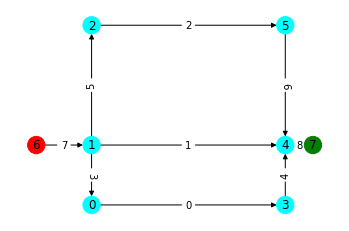

In [ ]:
#compute only once
special_network=CreateNetwork()
special_network.load_model("initial config")
special_network.draw_static()

In [ ]:
special_network_simulate=SimulateNetwork(special_network.return_network())#defining the network we use for our cost function

In [ ]:
def f(matrix_car_decision):
    """
    the cost function for one configuration

    Parameters
    ----------
        matrix_car_decision (list list int) : matrix of zeros and 1 with one 1 and 2 zeros in each sublist
                                            the outside list represent the number of car
                                            each sublist (the position of the 1) define the choice of road the car follow:
                                            [1,0,0] : (lowest label) road 1 : middle road
                                            [0,1,0] : road 3 : bottom road
                                            [0,0,1] : (the higuest label) road 5 : the top road
            
    Returns 
    -------
        (float) : the average time it take for the car to exit the system.
    """
    tensor_car_decision=[]
    n=10 #the number of cars place on the initial road
    l=0.01 #the size of the cars
    initial_road=("normal",7) #the road where we initially place the cars

    #transformation of the matrix choice in the tensor choice.
    for i in range(len(matrix_car_decision)):
        tensor_car_decision.append([matrix_car_decision[i]])

    #call to general method for our road network with the metaparameter define above
    return special_network_simulate.compute_global_time_with_control(n=n,l=l,initial_road=initial_road,tensor_car_decision=tensor_car_decision)

In [ ]:
def f2(matrix_car_decision) : 
    """
    the cost function for one configuration

    Parameters
    ----------
        matrix_car_decision (list list int) : matrix of zeros and 1 with one 1 and 2 zeros in each sublist
                                            the outside list represent the number of car
                                            each sublist (the position of the 1) define the choice of road the car follow:
                                            [1,0,0] : (lowest label) road 1 : middle road
                                            [0,1,0] : road 3 : bottom road
                                            [0,0,1] : (the higuest label) road 5 : the top road
            
    Returns 
    -------
        (float) : the average time it take for the car to exit the system.
    """
    tensor_car_decision=[]
    n=30 #the number of cars place on the initial road
    l=0.01 #the size of the cars
    initial_road=("normal",7) #the road where we initially place the cars

    #transformation of the matrix choice in the tensor choice.
    for i in range(len(matrix_car_decision)):
        tensor_car_decision.append([matrix_car_decision[i]])

    #call to general method for our road network with the metaparameter define above
    return special_network_simulate.compute_global_time_with_control(n=n,l=l,initial_road=initial_road,tensor_car_decision=tensor_car_decision)

In [ ]:
access=Access()
access.contain_file(file_name="test_several_car_type.mp4",path_to_directory="/content/drive/My Drive/Road_Network/result/video")

True

Cost function (pas utile)

In [ ]:
def ellapsed_time(cars_DataFrame,rank_time,car_number) :
    car_times = cars_DataFrame[(cars_DataFrame["car number"] == car_number) & (cars_DataFrame["rank time"] <= rank_time)]["elapsed time"]
    travel_time = car_times.iloc[-1] - car_times.iloc[0]
    return travel_time

def car_path(network_graph,car_weight,road_key) :
    network = network_graph.return_network()
    intersection = network.roads[road_key].i1
    return network.shortest_path(car_weight,intersection)

def Travel_Time_Cost(dt,network_graph,cars_DataFrame,roads_DataFrame) :
    list_dt_dataframes_cars = [ cars_DataFrame[cars_DataFrame["rank time"] == x] for x in cars_DataFrame["rank time"] ]
    list_travel_time = []
    times = []
    for df in list_dt_dataframes_cars :
        rank_time = df["rank time"].iloc[0]
        times.append(rank_time*dt)
        number_of_cars = len(df) 
        travel_time = 0
        for index , car in df.iterrows() : 
            car_number , car_weight , road_key = car["car number"] , car["weight class"] , car["current road"]
            path = car_path(network_graph,car_weight,road_key)[0]
            for k , key_road in enumerate(path) :
                road = roads_DataFrame.loc[ (roads_DataFrame["rank time"] == rank_time) & (roads_DataFrame["road key"] == key_road) ]
                if road.shape[0] != 0 :
                    L , Vmax , N = road["length"].values[0] , road["vmax"].values[0] , road["number of car"].values[0]
                    density = road["density"].values[0]
                    V = road["class speed"].values[0].speed(Vmax,0.1,0.1/density)
                    V = 0.001*(V == 0) + V*(V != 0)
                    x = 0
                    if k == 0 : x = car["road position"]
                    travel_time += (L-x) / V
            travel_time += ellapsed_time(cars_DataFrame,rank_time,car_number)
        travel_time /= number_of_cars
        list_travel_time.append(travel_time)
    return times , list_travel_time

# HOW ARE THE SECONDARY ROADS IMPACTS BY GPS ASSISTANCE ?

In [ ]:
# model constructor
crn4=CreateNetwork()

# ENTRY/EXIT & ROAD 4 CREATION 
crn4.add_intersection(label=0,cordX=0,cordY=100)
crn4.add_intersection(label=1,cordX=50,cordY=100)
crn4.add_intersection(label=2,cordX=50,cordY=200)
crn4.add_intersection(label=3,cordX=50,cordY=0)
crn4.add_intersection(label=4,cordX=150,cordY=200)
crn4.add_intersection(label=5,cordX=150,cordY=0)
crn4.add_intersection(label=6,cordX=150,cordY=100)
crn4.add_intersection(label=7,cordX=200,cordY=100)
crn4.add_intersection(label=8,cordX=100,cordY=200)
crn4.add_intersection(label=9,cordX=150,cordY=150)

crn4.set_entry(0)
crn4.set_exit(7)

crn4.linked_road([0,1,1,1,3,4,5,6,2,8,8,4,9],[1,2,6,3,5,6,6,7,8,4,9,9,6],[ x for x in range(13) ])

all_roads_key = list((crn4.return_network().roads).keys())

# ROAD'S PARAMETERS
eps = .1
vmax = 1
crn4.change_road_param(list_roads=all_roads_key,L = 1,vmax=vmax,class_speed=TruncatedLinearSpeed(eps))
crn4.change_road_param(list_roads=[("normal",2)],L = 5,vmax=vmax,class_speed=TruncatedLinearSpeed(eps))
crn4.change_road_param(list_roads=[("normal",8),("normal",9),("normal",11),("normal",12)],L = .5,vmax=vmax,class_speed=TruncatedLinearSpeed(eps))
crn4.change_road_param(list_roads=[("normal",1),("normal",3),("normal",4),("normal",6)],L = 1,vmax=vmax,class_speed=TruncatedLinearSpeed(eps))

# CreateNetwork to SimulateNetwork class
rn4=SimulateNetwork(crn4.return_network()) 
rn4.compile_car_system() 

crn4.draw_static()


unespected error


KeyError: ignored

In [ ]:
for x in (crn4.return_network()).shortest_path(Weight_Shortest_Distance(),1) :
    print(x,"\n \n")

[('normal', 3), ('normal', 4), ('normal', 6), ('normal', 7)] 
 

[('normal', 1), ('normal', 8), ('normal', 9), ('normal', 5), ('normal', 7)] 
 

[('normal', 1), ('normal', 8), ('normal', 10), ('normal', 12), ('normal', 7)] 
 

[('normal', 1), ('normal', 8), ('normal', 9), ('normal', 11), ('normal', 12), ('normal', 7)] 
 



In [ ]:
(crn4.return_network()).intersections[1].next_road[Weight_Shortest_Distance()]

[('normal', 2)]

In [ ]:
length = .1
dt = length/2

time = 10
t_data = .1
t_plot = .2

flow = .9
def entry_flow(t) : 
    return flow*(t<=6) 

In [ ]:
percent_list = [ x/5 for x in range(6) ]
L_roads = []
for x in percent_list : L_roads.append(rn4.run_get_all_info(dt,time,entry_flow,proportion_types=[1-x,0,0,x],length=length,t_data=t_data,t_plot=t_plot,density=False,random=False,video=False,show=False)[1])

---------------------- Max flow allowed : 0.9 ----------------------
---------------------- Max flow allowed : 0.9 ----------------------
---------------------- Max flow allowed : 0.9 ----------------------
---------------------- Max flow allowed : 0.9 ----------------------
---------------------- Max flow allowed : 0.9 ----------------------
---------------------- Max flow allowed : 0.9 ----------------------


In [ ]:
for x in L_roads :
    print(len(x[x["road number"] == 3]))

0
0
0
0
0
0


In [ ]:
L_roads[0]

road type  road number  rank time  number of car  density  length  vmax  \
0      normal          0.0        0.0            1.0      1.0     1.0   1.0   
1      normal          0.0        2.0            1.0      1.0     1.0   1.0   
2      normal          0.0        4.0            2.0      2.0     1.0   1.0   
3      normal          0.0        6.0            3.0      3.0     1.0   1.0   
4      normal          0.0        8.0            3.0      3.0     1.0   1.0   
..        ...          ...        ...            ...      ...     ...   ...   
195    normal          7.0      196.0            3.0      3.0     1.0   1.0   
196    normal          2.0      198.0           32.0      6.4     5.0   1.0   
197    normal          7.0      198.0            2.0      2.0     1.0   1.0   
198    normal          2.0      199.0           32.0      6.4     5.0   1.0   
199    normal          7.0      199.0            2.0      2.0     1.0   1.0   

                                          class speed  
0    linear speed calculation function, epsilon : 0.1  
1    linear speed calculation function, epsilon : 0.1  
2    linear speed calculation function, epsilon : 0.1  
3    linear speed calculation function, epsilon : 0.1  
4    linear speed calculation function, epsilon : 0.1  
..                                                ...  
195  linear speed calculation function, epsilon : 0.1  
196  linear speed calculation function, epsilon : 0.1  
197  linear speed calculation function, epsilon : 0.1  
198  linear speed calculation function, epsilon : 0.1  
199  linear speed calculation function, epsilon : 0.1  

[200 rows x 8 columns]

# BRAESS PARADOX

Network creation

In [ ]:
def braess_paradox_case(dt,time,flow_function,eps,length,t_data=1,t_plot=1,middle_road=False,show=False) :

    ###############  NETWORK CREATION  ###############
    # model constructor
    crn=CreateNetwork()

    #then use the grid function to automaticly create a little network
    crn.create_grid(width_level=2,width_road_size=100,length_level=2,length_road_size=100,vmin = 1e-7,vmax=50,vclass=TruncatedLinearSpeed(),size=2)

    # ENTRY/EXIT & ROAD 4 CREATION 
    crn.add_intersection(label=4,cordX=-100,cordY=-100) # add some intersection
    crn.add_intersection(label=5,cordX=300,cordY=300)
    crn.linked_road([4,3],[0,5],[4,5])
    crn.set_entry(4)
    crn.set_exit(5)
    usual_speedlaw_road_list = [("normal",0),("normal",1)] 
    if middle_road :
        crn.add_road(6,2,1) 
        usual_speedlaw_road_list.append(("normal",6))      

    # ROAD'S PARAMETERS
    vmax = 1
    crn.change_road_param(list_roads=[("normal",4),("normal",5)],L = 1,vmax=vmax,class_speed=TruncatedLinearSpeed(eps))
    crn.change_road_param(list_roads=[("normal",3),("normal",2)],L = 2.1,vmax=vmax,class_speed=TruncatedLinearSpeed(eps))
    crn.change_road_param(list_roads=usual_speedlaw_road_list,L = 1,vmax=vmax,class_speed=TruncatedLinearSpeed(1)) 

    # CreateNetwork to SimulateNetwork class
    rn=SimulateNetwork(crn.return_network()) 
    rn.compile_car_system() 

    ###############  SIMULATION  ###############
    cars , roads = rn.run_get_all_info(dt,time,flow_function,proportion_types=[1,0,0,0],length=length,t_data=t_data,t_plot=t_plot,density=False,random=False,video=False,show=show)

    ###############  TRAVEL TIME CALCULATION  ###############
    list_travel_time = []
    list_initial_car_time = []
    for k in range(0,len(set(cars["car number"]))) : 
        t_final = cars[cars["car number"] == k].iloc[-1]["elapsed time"]
        t_initial = cars[cars["car number"] == k].iloc[0]["elapsed time"]
        list_initial_car_time.append(t_initial)
        list_travel_time.append(t_final-t_initial)

    return crn , list_initial_car_time , list_travel_time , cars , roads

Parameters

In [ ]:
eps = .1
length = .1
dt = length/2

time = 10
t_data = .1
t_plot = .2

flow = .5
def entry_flow(t) : 
    return flow*(t<=6) 

Simulation

In [ ]:
show = False
crn_4_roads , x1 , y1 , cars , roads = braess_paradox_case(dt,time,entry_flow,eps=eps,length=length,t_data=t_data,t_plot=t_plot,middle_road=False,show=show)
crn_5_roads , x2 , y2 , cars2 , roads2 = braess_paradox_case(dt,time,entry_flow,eps=eps,length=length,t_data=t_data,t_plot=t_plot,middle_road=True,show=show)

---------------------- Max flow allowed : 0.9 ----------------------
---------------------- Max flow allowed : 0.9 ----------------------


------------------------------------------------ **PLOT** ------------------------------------------------

4 ROADS


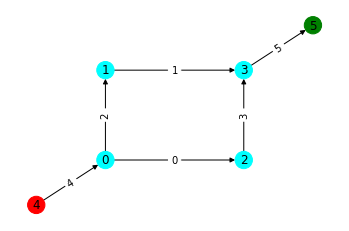

5 ROADS


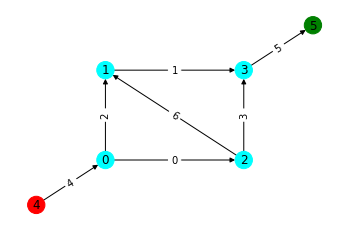

In [ ]:
print("4 ROADS")
crn_4_roads.draw_static()
print("5 ROADS")
crn_5_roads.draw_static()

Flow as a function of density

fmax = 0.9


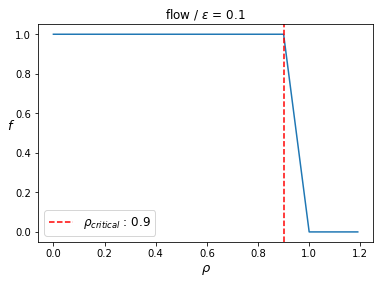

In [ ]:
def flow_TruncatedLinearSpeed(rho) :
    return max(min(1,(1-rho)/eps),0)

if eps > .5 : 
    critical_rho = .5
    fmax = 1/(4*eps)
else : 
    critical_rho = 1-eps
    fmax = 1-eps
print("fmax = "+str(fmax))

rho = np.arange(0,1.2,0.01)
F = [ flow_TruncatedLinearSpeed(x) for x in rho ]

plt.plot(rho,F)
plt.axvline(x=critical_rho,color="r",linestyle="--",label=r"$\rho_{critical}$ : "+str(critical_rho))
plt.title(r'flow / $\epsilon$ = {}'.format(eps))
plt.xlabel(r"$\rho$", fontsize=13)
plt.ylabel(r"$f$",rotation=0, fontsize=13)
plt.legend(fontsize=12);

Number of car on the first road of the graph :

In [ ]:
# 4 ROADS
L = []
T = []
List_rank_time = list(set(cars["rank time"]))
List_rank_time = [List_rank_time[x] for x in np.argsort(List_rank_time)]
for i in List_rank_time : 
    T.append(i*dt)
    L.append(len(cars[(cars["rank time"] == i) & (cars["current road"] == cars["current road"].iloc[0])]))

# 5 ROADS
L2 = []
T2 = []
List_rank_time2 = list(set(cars2["rank time"]))
List_rank_time2 = [List_rank_time2[x] for x in np.argsort(List_rank_time2)]
for i in List_rank_time2 : 
    T2.append(i*dt)
    L2.append(len(cars2[(cars2["rank time"] == i) & (cars2["current road"] == cars2["current road"].iloc[0])]))

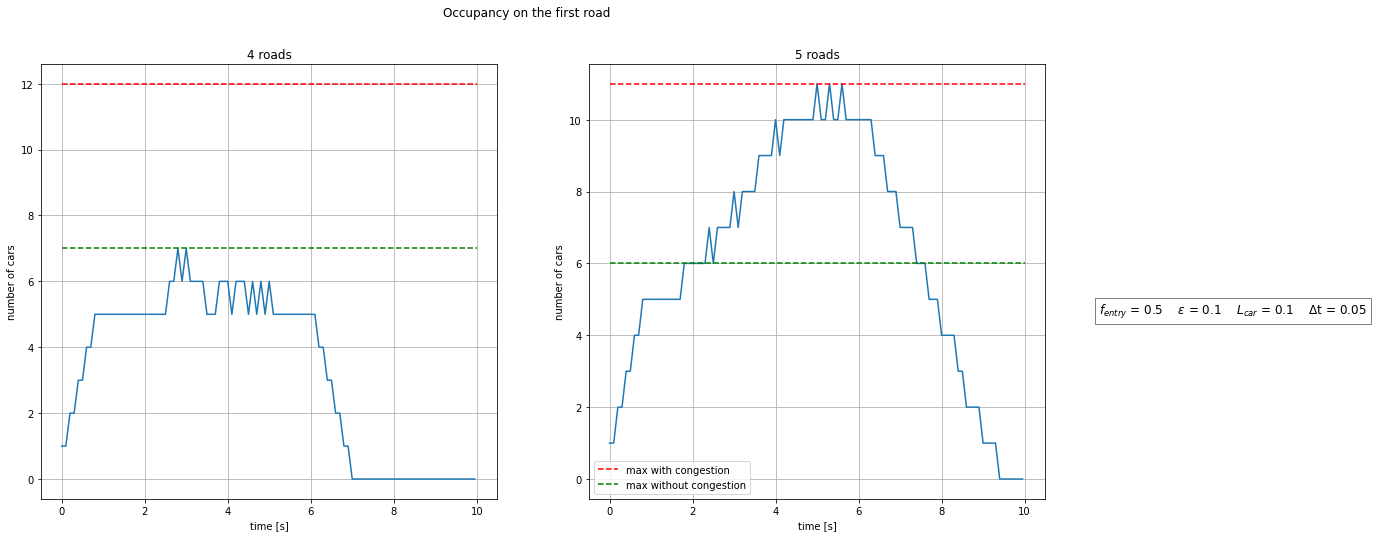

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,8))
fig.suptitle("Occupancy on the first road")

# 4 ROADS
ax1.plot(T,L)
ax1.plot(np.linspace(0,10,2),[2+1/length]*2,color="r",ls="--")
ax1.plot(np.linspace(0,10,2),[2+1/(length/flow)]*2,color="g",ls="--")
ax1.set_title("4 roads")
ax1.text(25,1/length/2,r'$f_{entry}$ = '+str(entry_flow(0))+'    $\epsilon$ = '+str(eps)+'    $L_{car}$ = '+str(length)+'    $\Delta$t = '+str(dt),
        bbox={'facecolor': 'white', 'alpha': 0.5},ma='center',fontsize=12)
ax1.grid()
ax1.set_xlabel("time [s]")
ax1.set_ylabel("number of cars")

# 5 ROADS
ax2.plot(T2,L2)
ax2.plot(np.linspace(0,10,2),[1+1/length]*2,color="r",ls="--",label="max with congestion")
ax2.plot(np.linspace(0,10,2),[1+1/(length/flow)]*2,color="g",ls="--",label="max without congestion")
ax2.set_title("5 roads")
ax2.grid()
ax2.set_xlabel("time [s]")
ax2.set_ylabel("number of cars")
ax2.legend()

plt.show()

In [ ]:
n_cars = len(set(cars["car number"])) , len(set(cars2["car number"]))
print("Number of cars \n | 4 roads : {} \n | 5 roads : {}".format(n_cars[0],n_cars[1]))

Number of cars 
 | 4 roads : 31 
 | 5 roads : 28


Cost evaluation

In [ ]:
# KERNEL INTERPOLATION

from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as k

kernel = k.RBF(length_scale=1.0, length_scale_bounds=(.5, 1.5))

xnew = np.linspace(0,6,60)

gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(np.atleast_2d(x1).T, y1)
gp2 = GaussianProcessRegressor(kernel=kernel)
gp2.fit(np.atleast_2d(x2).T, y2)

# The 2D and [:, None] stuff is because the object expects 2D data in, not 1D
y_mean, y_std = gp.predict(xnew[:, None], return_std=True)
y_mean2, y_std2 = gp2.predict(xnew[:, None], return_std=True)

# plt.scatter(x1, y1, s=30,alpha=.1,color="b")
# plt.scatter(x2, y2, s=30,alpha=.1,color="orange")

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.5. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.5. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


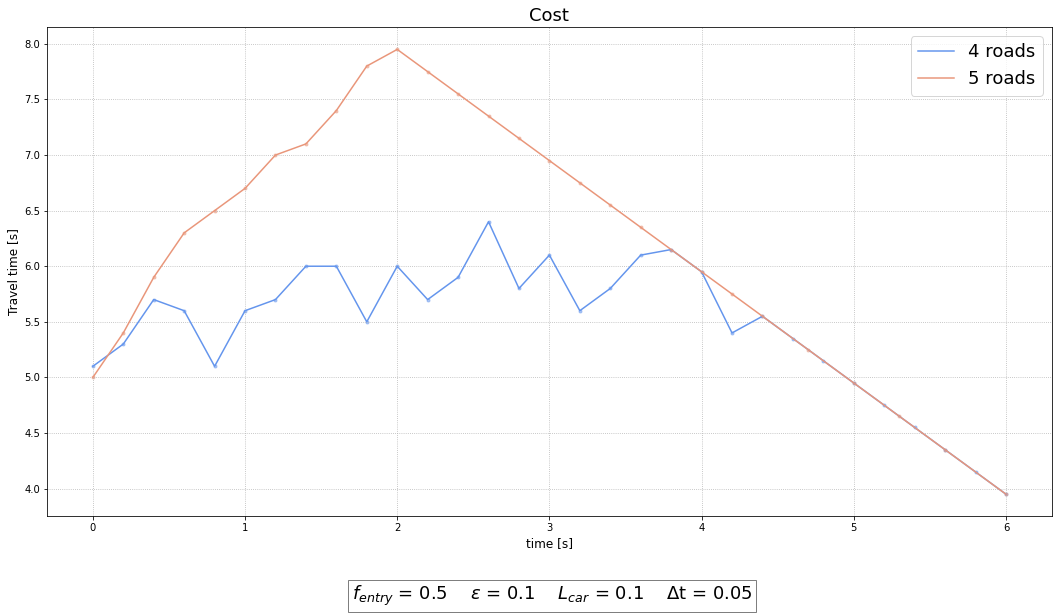

In [ ]:
height = 18
fig, ax = plt.subplots(figsize=(height,height/2))

ax.scatter(x1, y1,color='cornflowerblue',marker='.',alpha=.5)
ax.scatter(x2, y2,color='darksalmon',marker='.',alpha=.5)
# ax.plot(xnew, y_mean,label="4 roads",color='cornflowerblue')
# ax.plot(xnew, y_mean2,label="5 roads",color='darksalmon')
ax.plot(x1, y1,label="4 roads",color='cornflowerblue')
ax.plot(x2, y2,label="5 roads",color='darksalmon')
ax.text(1.7,3,r'$f_{entry}$ = '+str(entry_flow(0))+'    $\epsilon$ = '+str(eps)+'    $L_{car}$ = '+str(length)+'    $\Delta$t = '+str(dt),
        bbox={'facecolor': 'white', 'alpha': 0.5},ma='center',fontsize=height)

ax.set_xlabel("time [s]",fontsize=height*2/3)
ax.set_ylabel("Travel time [s]",fontsize=height*2/3)
ax.set_title("Cost",fontsize=height)

ax.legend(fontsize=height)
ax.grid(linestyle=':') 

# RANDOM CIRCLE

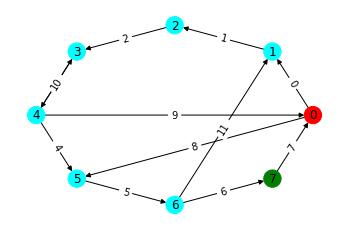

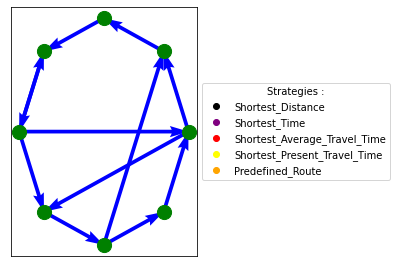

In [ ]:
# model constructor
crn3=CreateNetwork()

#then use the grid function to automaticly create a little network
n = 8
crn3.create_traffic_circle(n,list_out_road_length=[],list_road_length=[],list_direction=[3]*n,vm=1,vclass=TruncatedLinearSpeed(),coeff_size=1)

crn3.set_entry(0)
crn3.set_exit(n-1)

p = 0
for i in range(n):
    for j in range(n-i) :
        if j != i and rd.choice(np.arange(0,n//2)) == 0 :
            crn3.add_road(n+p,i,j,vclass = TruncatedLinearSpeed(),L=1,vm=1)
            p += 1

rn3 = SimulateNetwork(crn3.return_network())

# rn3.position_car_uniform(2,type0=3,l=1e-3)

crn3.draw_static()
rn3.draw_car()

# ONLY ONE ROAD

In [ ]:
dt3 = 0.01

eps3 = 0.1
length3 = eps3/2

time3 = 15
t_data3 = .1
t_plot3 = .2

def entry_flow3(t) : 
    return .5*(t<=6) 

In [ ]:
crn3=CreateNetwork()
crn3.add_intersection(label=0,cordX=-100,cordY=-100) # add some intersection
crn3.add_intersection(label=1,cordX=300,cordY=300)
crn3.set_entry(0)
crn3.set_exit(1)
crn3.add_road(0,0,1) 

crn3.change_road_param(list_roads=[("normal",0)],L = 1,vmax=1,class_speed=TruncatedLinearSpeed(eps3))
rn3=SimulateNetwork(crn3.return_network()) 
rn3.compile_car_system() 

cars3 , roads3 = rn3.run_get_all_info(dt3,time3,entry_flow3,proportion_types=[1,0,0,0],length=length3,t_data=t_data3,t_plot=t_plot3,density=False,random=False,video=False,show=False)